<a href="https://colab.research.google.com/github/shawonsheikh-byte/AI/blob/main/sepsis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Importing and splitting the data into training and testing

In [48]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

combined = pd.read_csv('Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [49]:
# importing the test and training data

df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

# Exploratory data analysis

In [50]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


As can be seen, this is a time series data. The dataframe has 44 columns. After the first loook at data, it can be observed that the data seems quite sparse.

In [51]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [52]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [53]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
# Percentage of null values present in all the parameters

null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
EtCO2,100.000000
TroponinI,99.877881
Bilirubin_direct,99.850420
Fibrinogen,99.236917
Bilirubin_total,98.773372
Alkalinephos,98.540650
AST,98.504205
Lactate,96.565112
PTT,95.152459
SaO2,95.044387



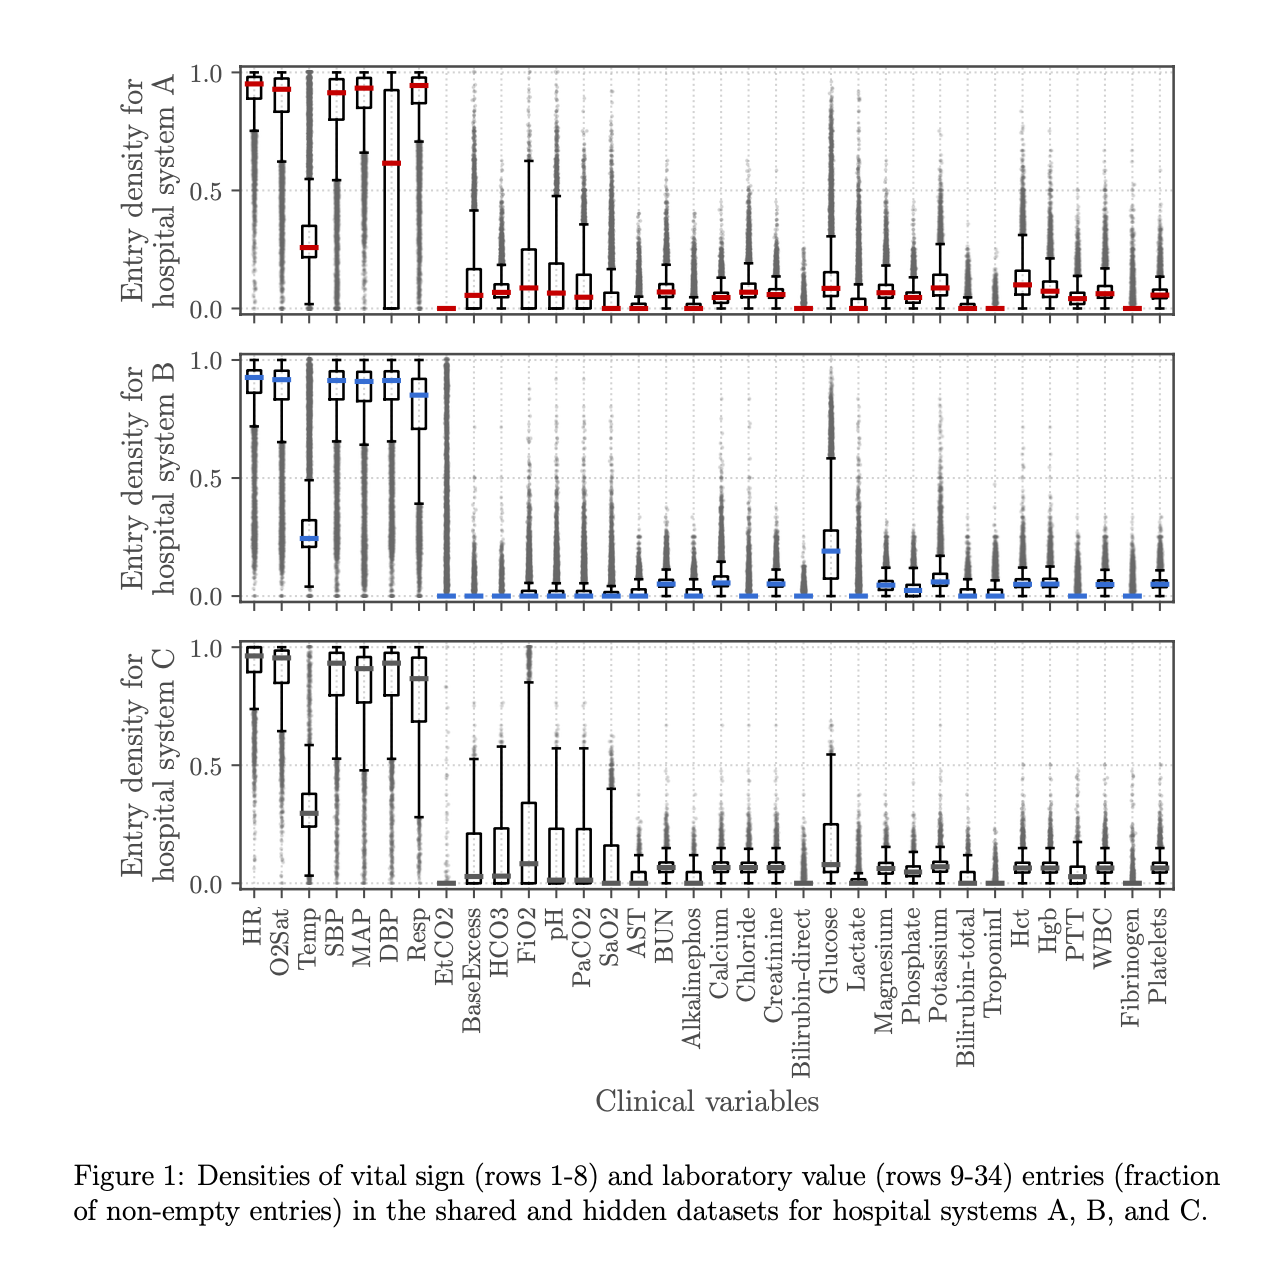

Image obtained from the official pdf of the PhysioNet Challenge. The image gives an overall idea of the number of records available for each feature, for all the three datasets of three different hospitals.

After thorough analysis of the data, it was found that a lot of the features were redundant, i.e. a lot of the features were indicative of the same parameter, so those features were removed on the basis of their sparsity. Another criteria taken into consideration was ease of getting the parameter among different hospitals, becuase some of the parameters are easier to obtain for a given hospital while some are expensive and for some a hospital does not even have infrastructure to get those features.

In [55]:
# the features have been removed based on the number of null values and redundancy

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

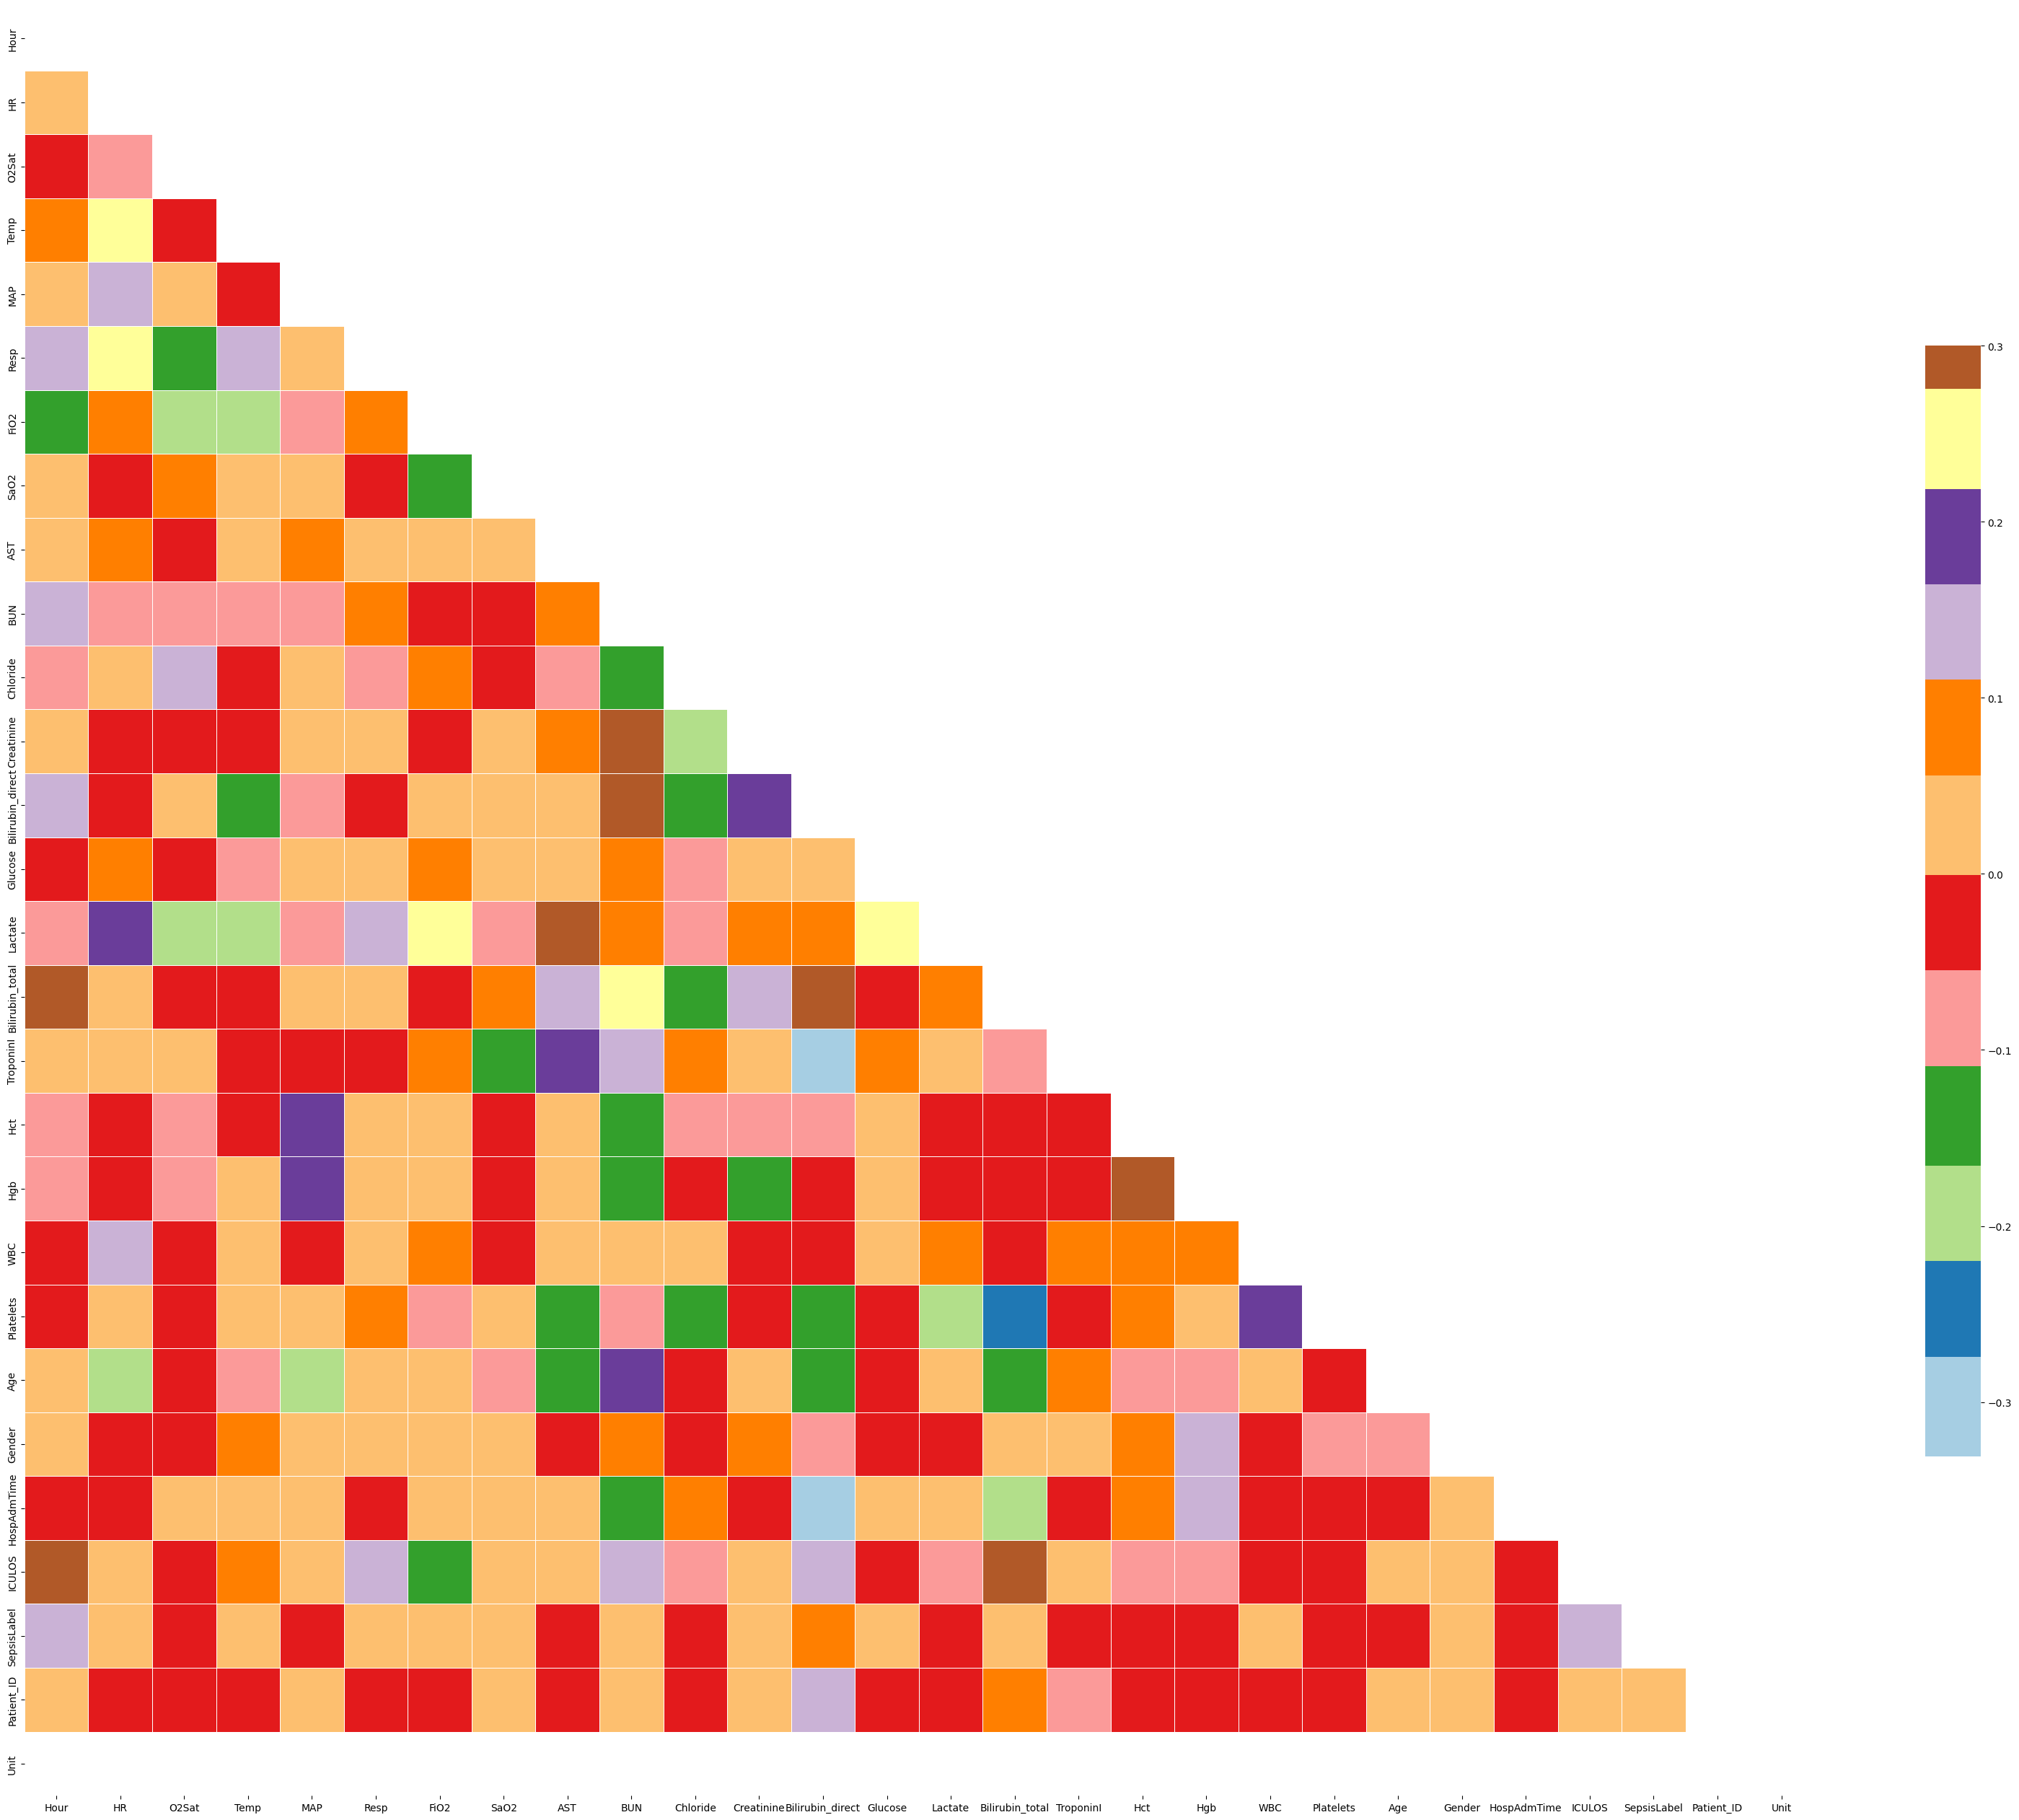

In [56]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

As can be seen in this correlation heat map almost all of the feature do not have high correlation.

# Imputation

Since there are a lot of missing values in the dataset, therefore imputation was done to fill the missing values. While imputing, it is important to note that ***imputation should be done on per patient basis,*** otherwise the data from one patient will leak into the data of the other patient. Also another point that should be taken into consideration is that mean, median, mode can not directly be used to impute as it will result in uneven distribution of the parameters with respect to time.

In [57]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [58]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/tmp/ipython-input-468124072.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [59]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                    
1          132940     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                    BUN  ...   Hgb  WBC  Platelets    Age  Gender  \
Patient_ID               ...                                        
1          132940  14.0  ...  12.5  5.7      317.0  83.14       0   
           132941  14.0  ...  12.5  5.7      317.0  83.14       0   
           132942  14.0  ...  12.5  5.7      317.0  83.14       0   
           132943  14.0  ...  12.5  5.7      317.0  83.14       0   
           132944  14.0  ...  12.5  5.7      317.0  83.14       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [60]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,97.357934
Bilirubin_direct,96.256841
Bilirubin_total,66.949754
AST,66.435590
SaO2,57.282891
Lactate,55.997418
Unit,48.868346
FiO2,36.195592
WBC,1.511994
Platelets,1.394810


'TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID'  have more than 25 percent of null values and hence are dropped from the dataset.

In [61]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [62]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)


## Gaussian Transformation and Standard Normalization

Generally models tend to give a better result for a normal ditribution. So in the below cells we explored different techniques to plot histograms and QQ plots of all the features and then we applied different transformations on it to see which were giving good results. The ones giving the beest results were then adopted in the dataframe.

In [63]:
# function to draw histogram and QQ plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [64]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # Create a copy to avoid SettingWithCopyWarning
  df_copy = df.copy()
  # this applies yeojohnson plot
  df_copy['col_yj'], param = stats.yeojohnson(df_copy[col])
  print('yeojohnson plot')
  diagnostic_plots(df_copy, 'col_yj')
  # this applies exponential transformation
  df_copy['col_1.5'] = df_copy[col]**(1/1.5)
  print('**1/1.5 plot')
  diagnostic_plots(df_copy, 'col_1.5')
  df_copy['col_.5'] = df_copy[col]**(.5)
  print('**.5 plot')
  # this applies inverse transformation
  diagnostic_plots(df_copy, 'col_.5')
  df_copy['col_rec'] = 1 / (df_copy[col]+0.00001)
  diagnostic_plots(df_copy, 'col_rec')
  # this applies logarithmic trasnformation
  df_copy['col_log'] = np.log(df_copy[col]+1)
  diagnostic_plots(df_copy, 'col_log')

O2Sat
actual plot


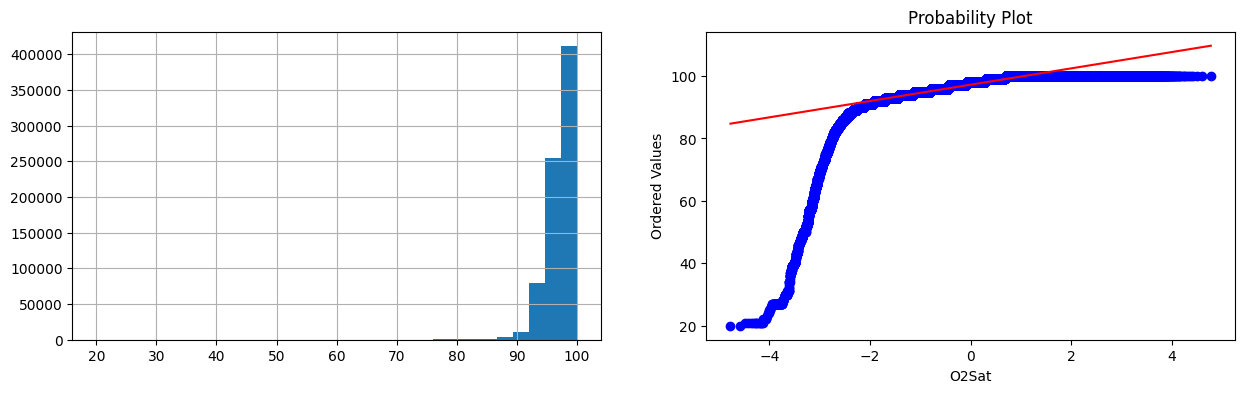

yeojohnson plot


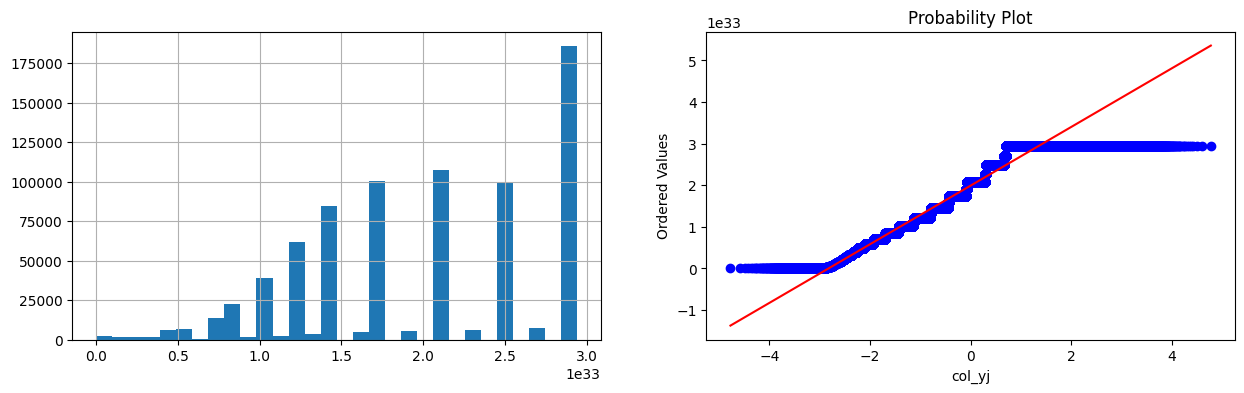

**1/1.5 plot


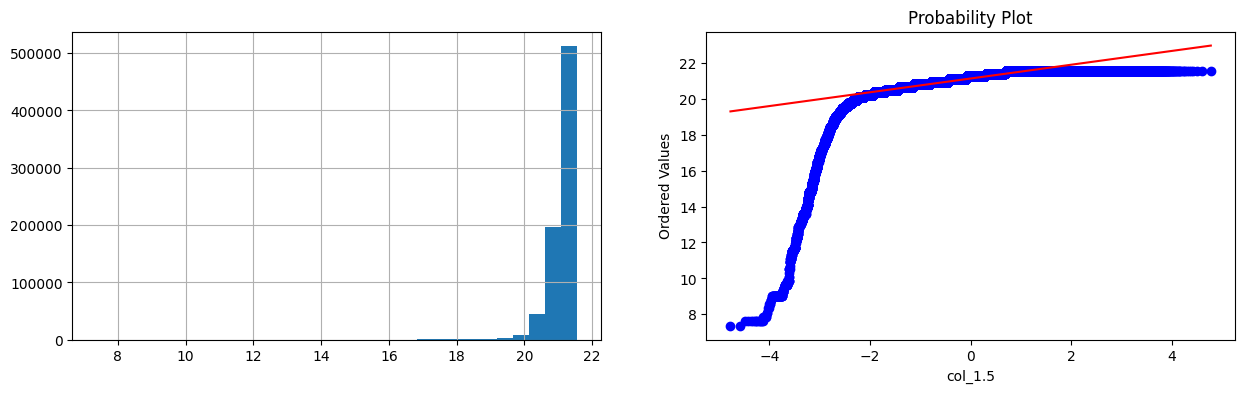

**.5 plot


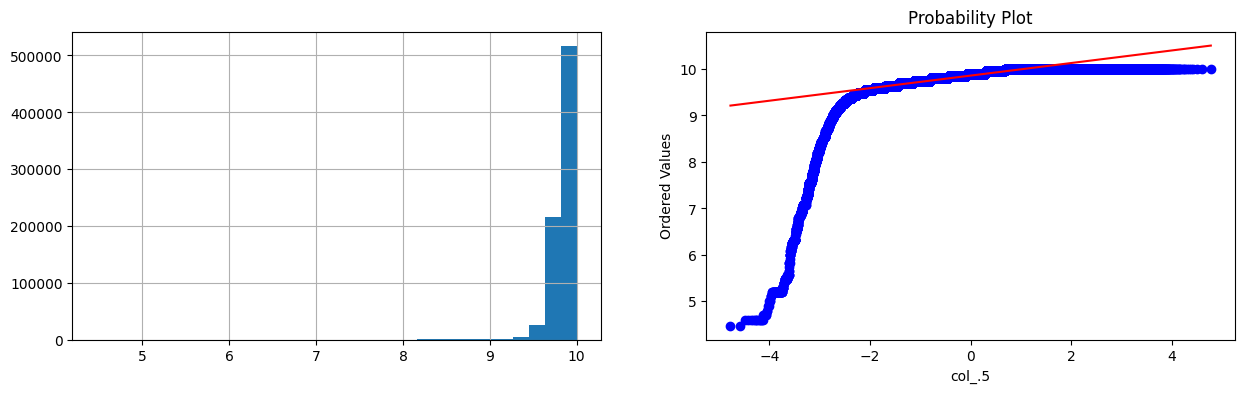

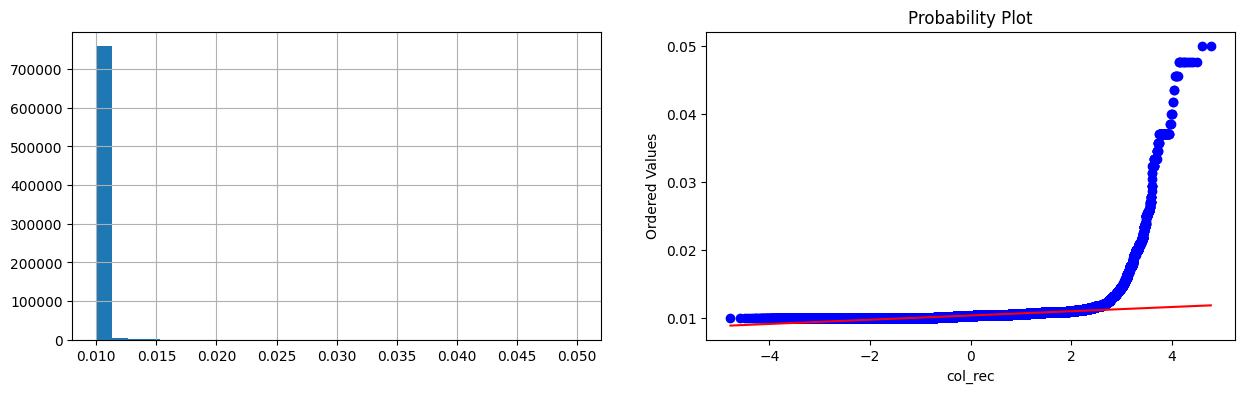

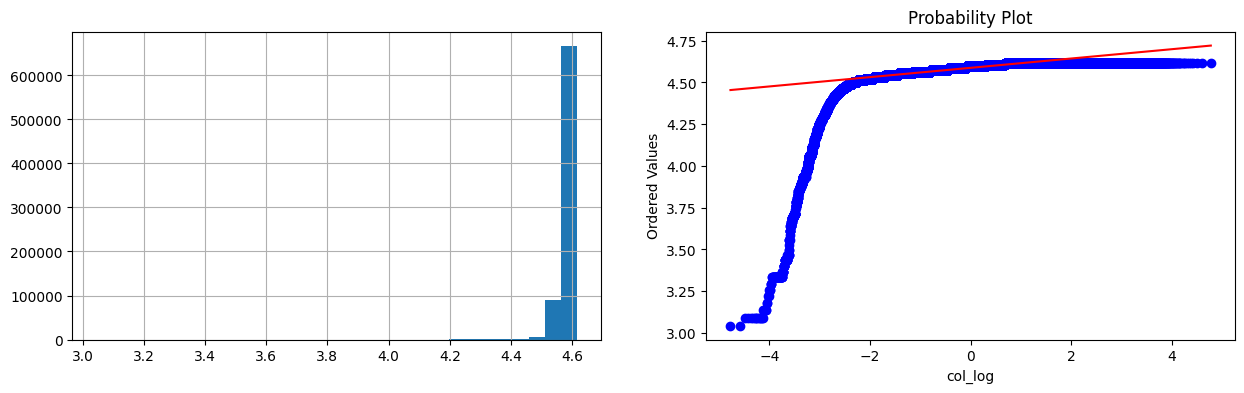

Temp
actual plot


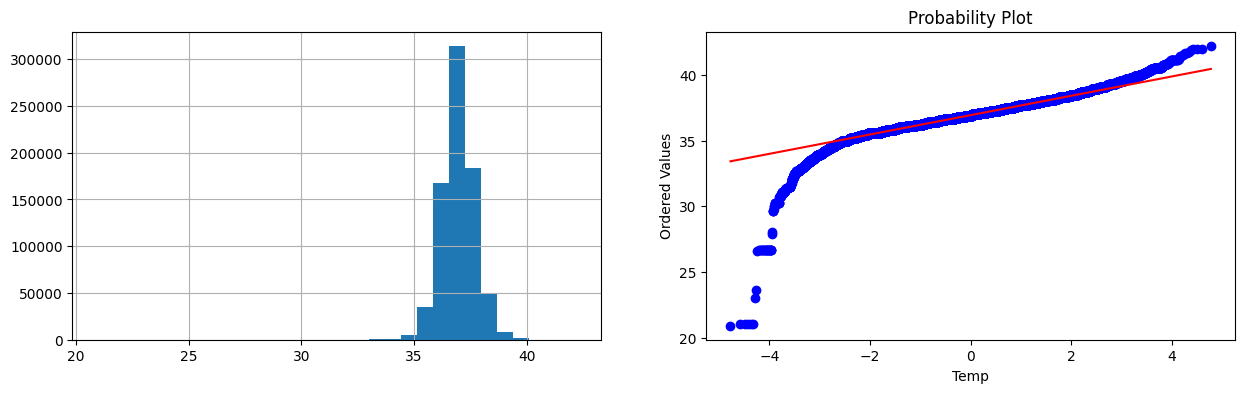

yeojohnson plot


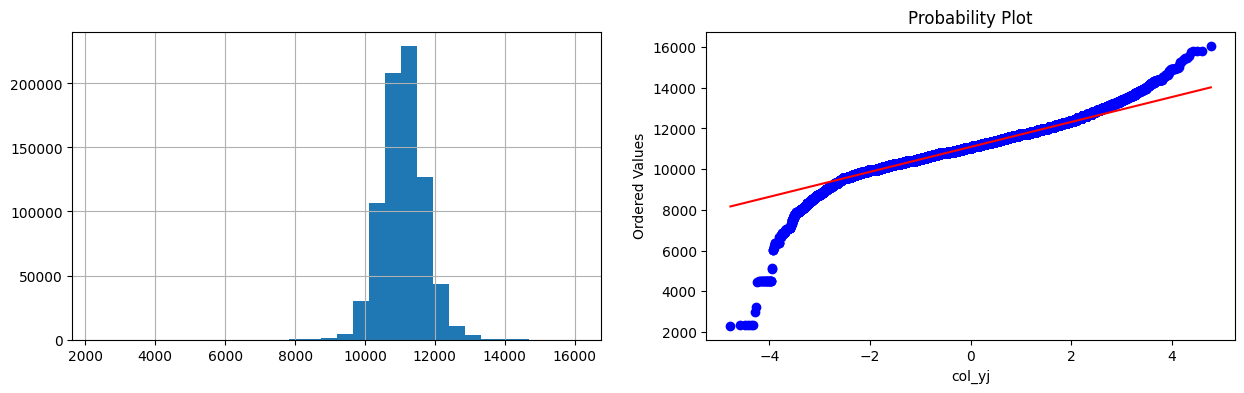

**1/1.5 plot


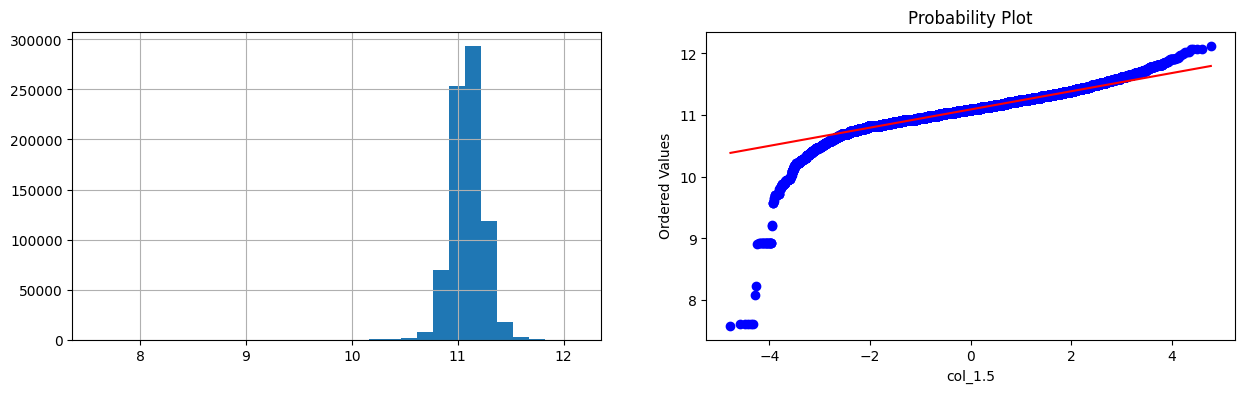

**.5 plot


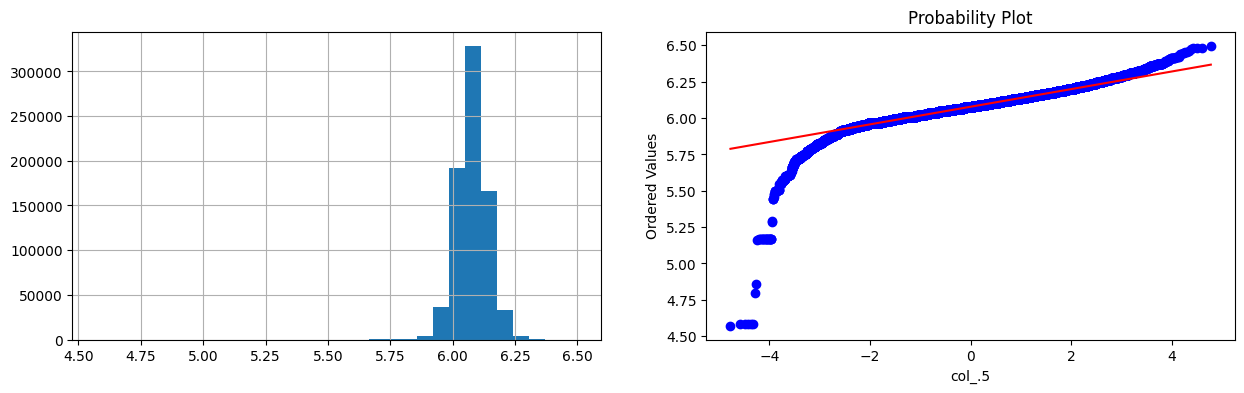

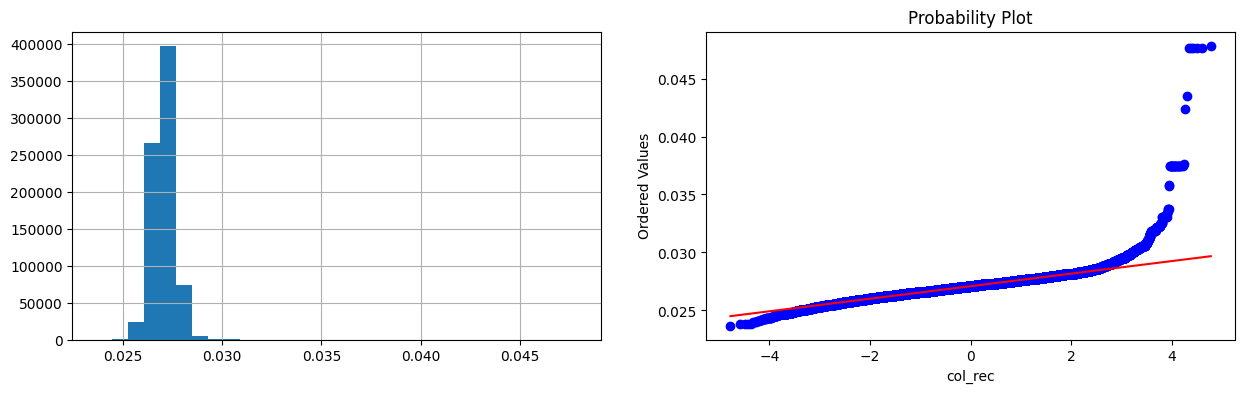

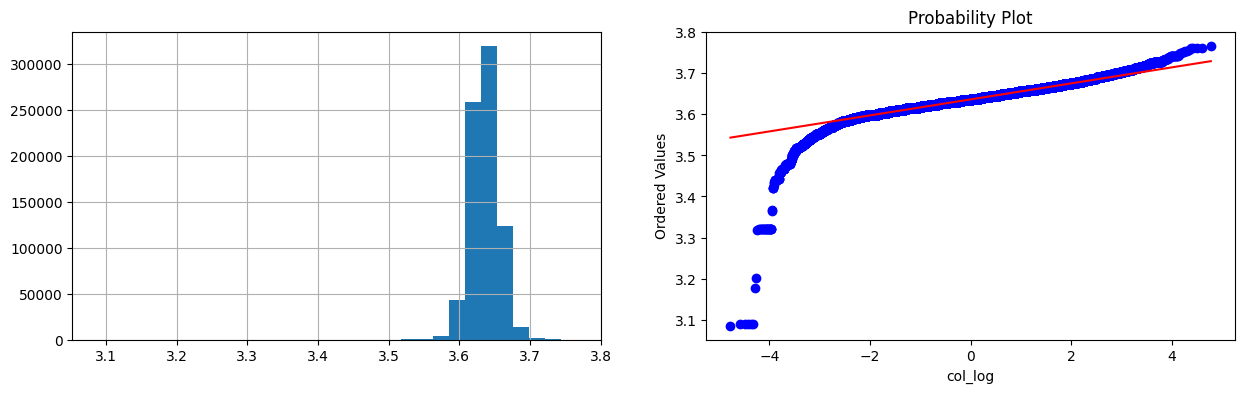

MAP
actual plot


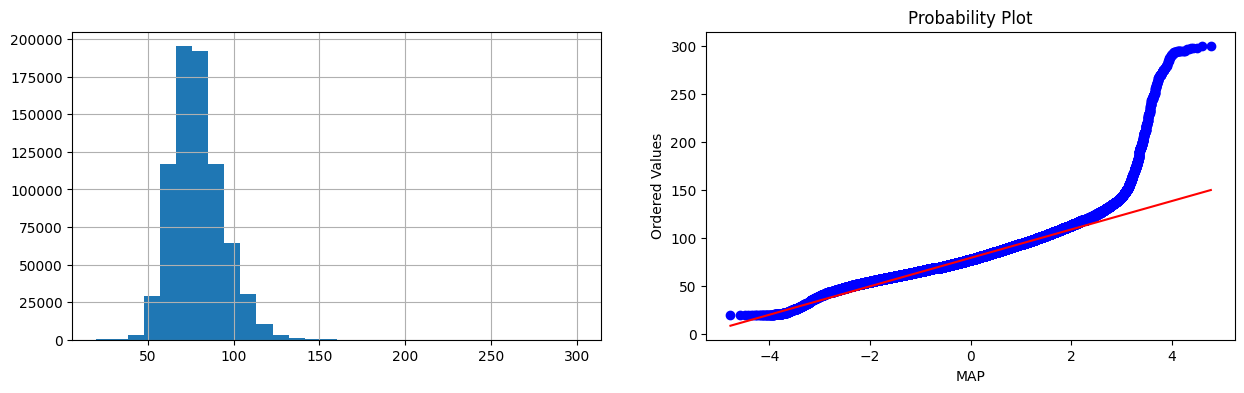

yeojohnson plot


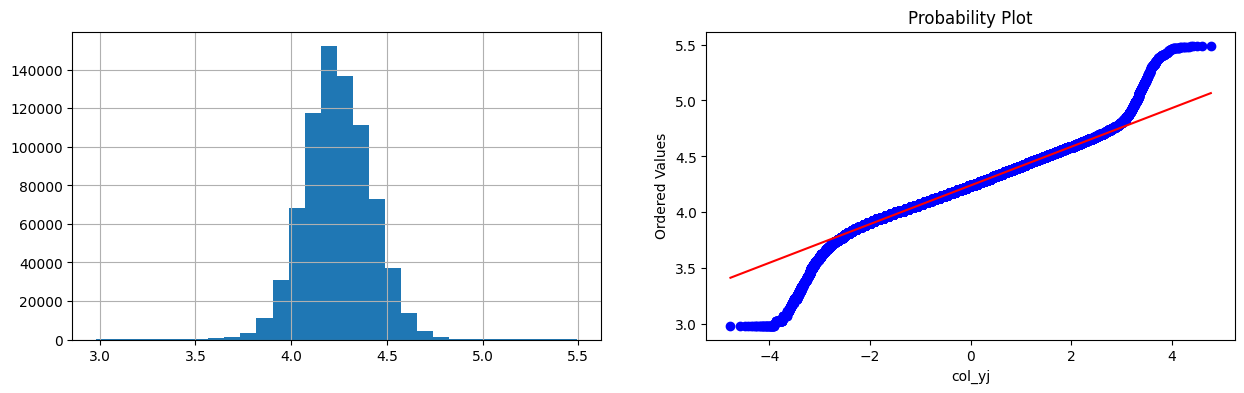

**1/1.5 plot


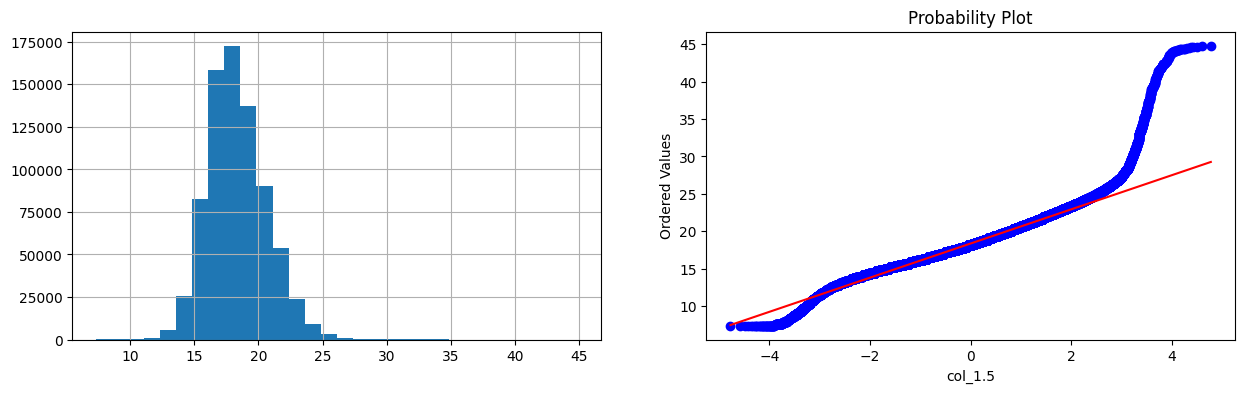

**.5 plot


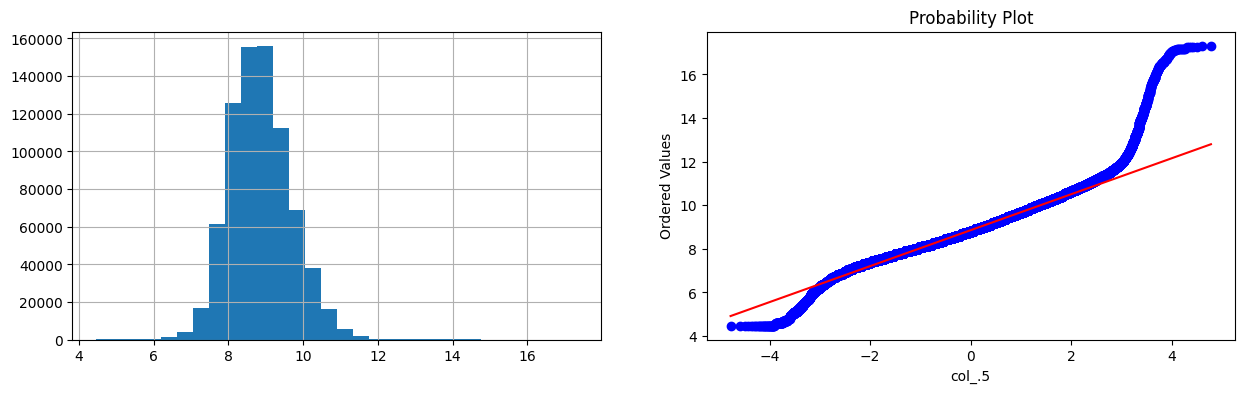

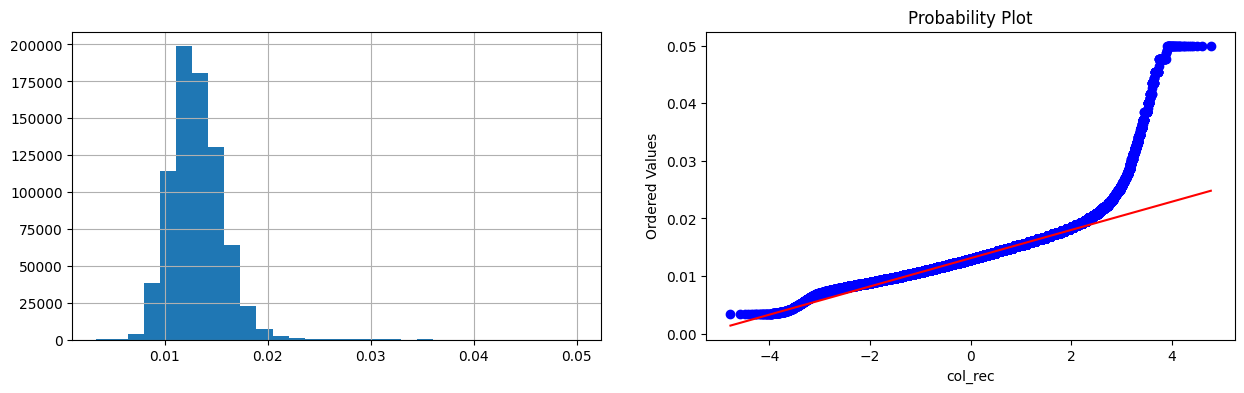

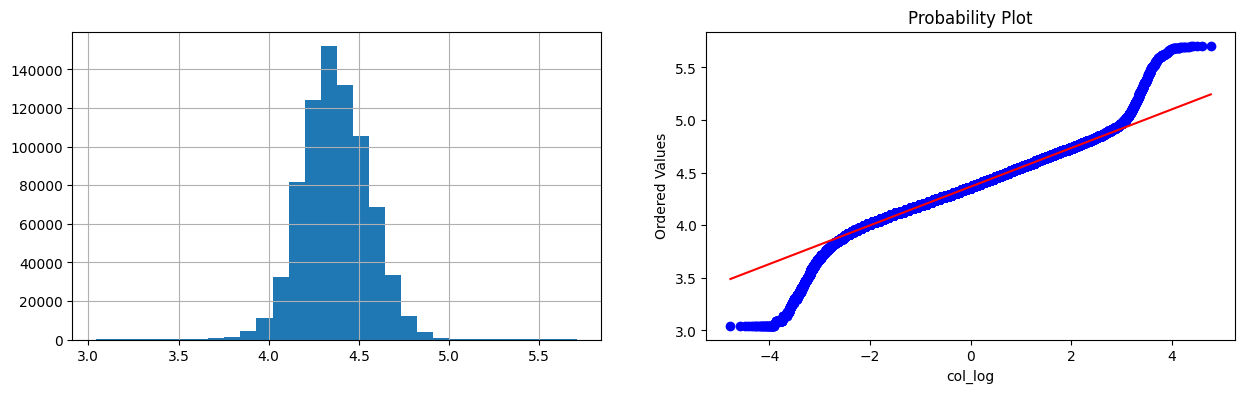

BUN
actual plot


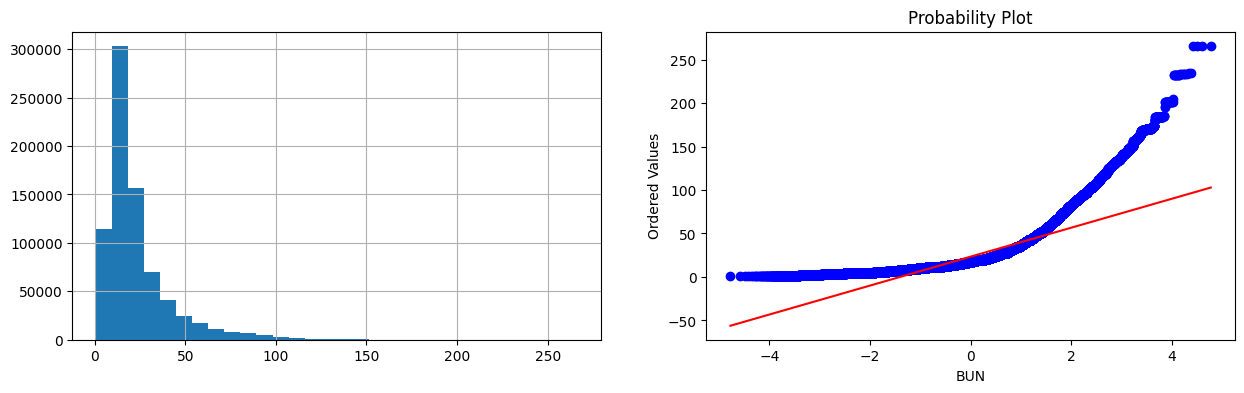

yeojohnson plot


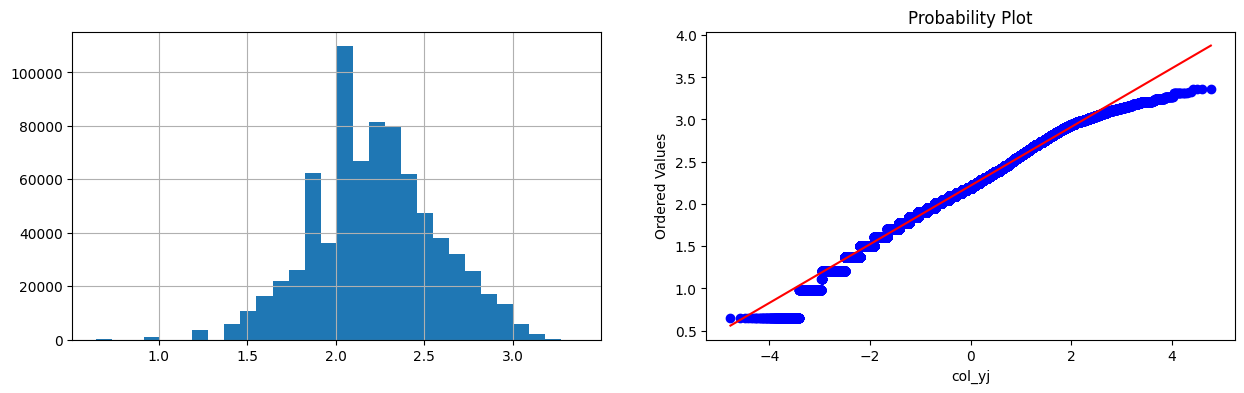

**1/1.5 plot


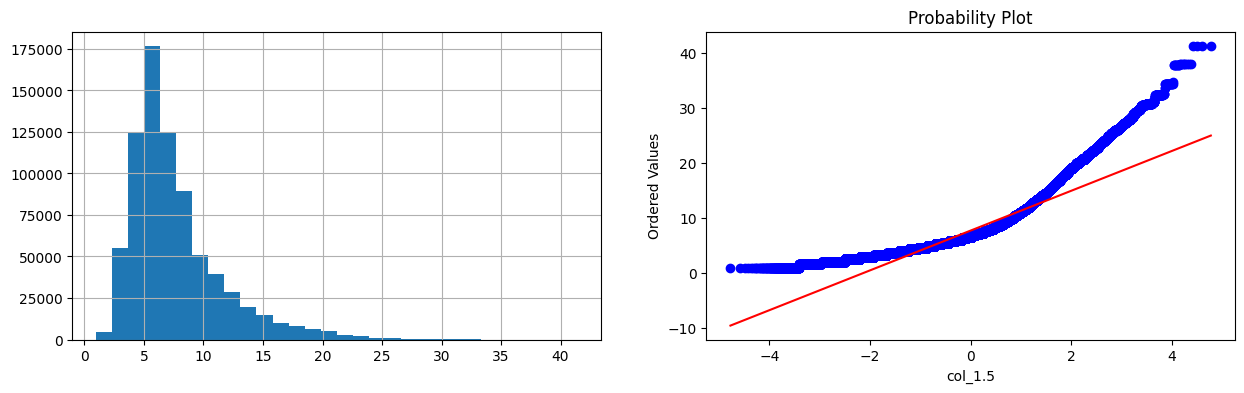

**.5 plot


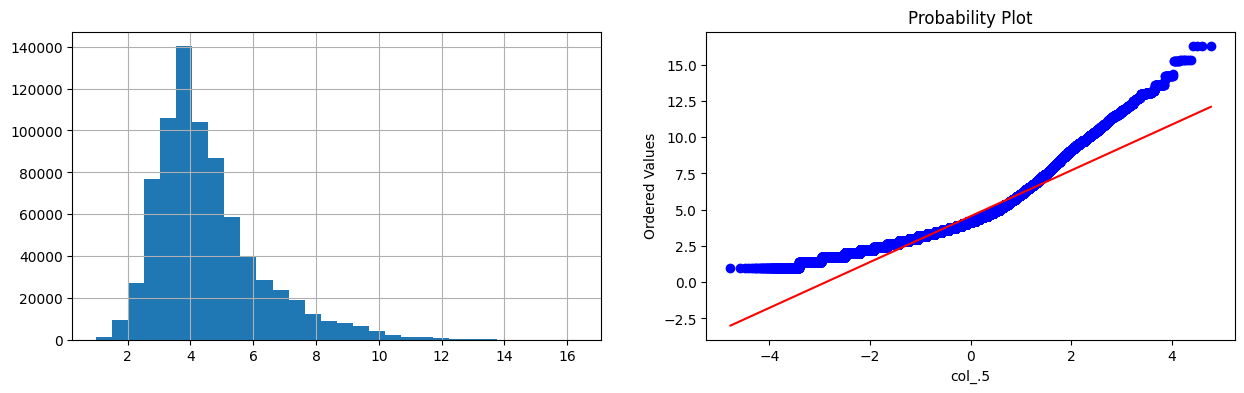

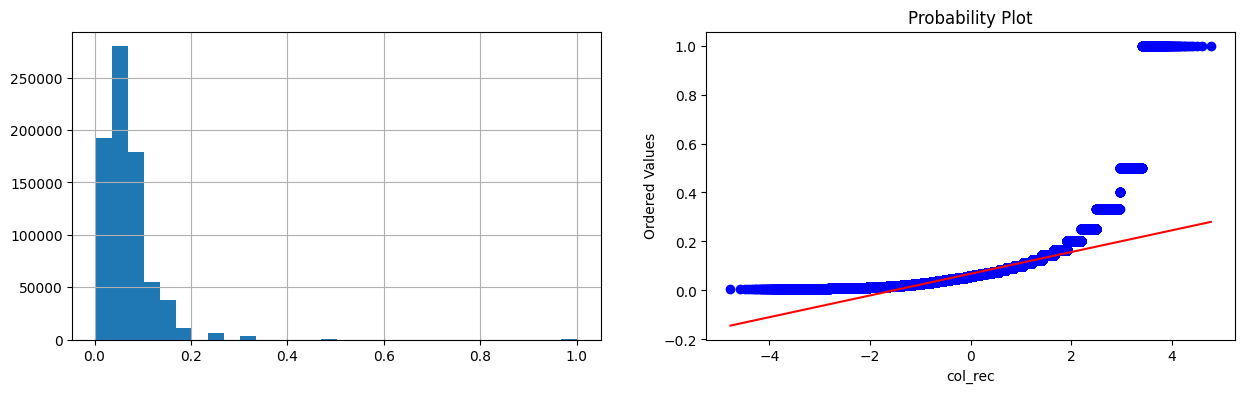

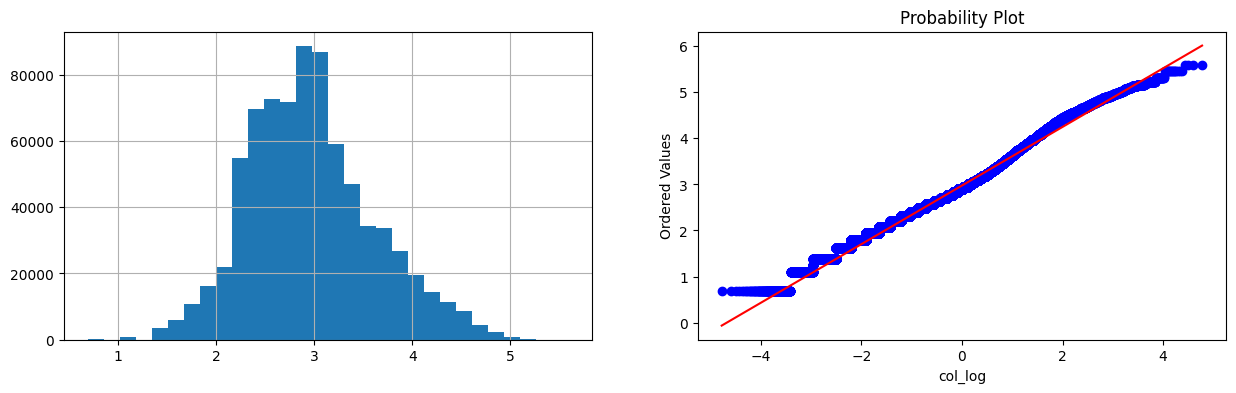

Creatinine
actual plot


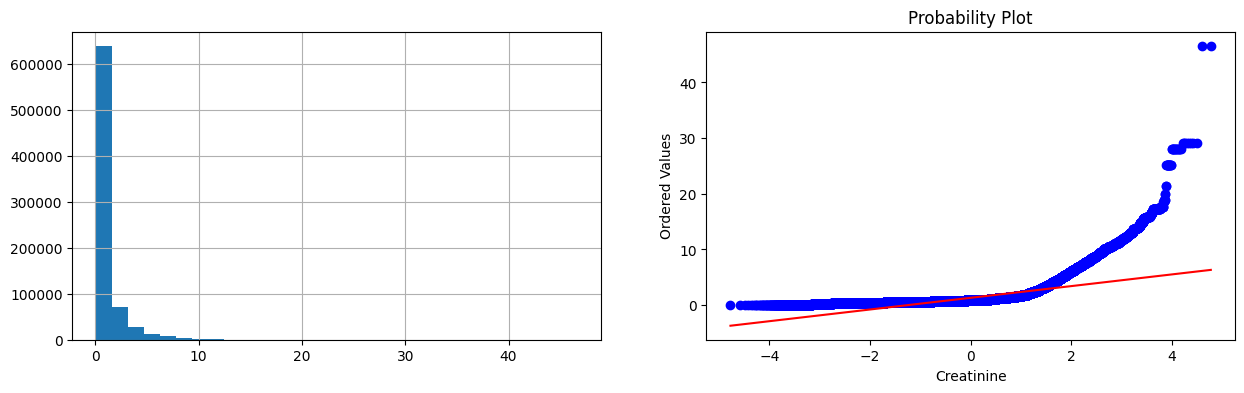

yeojohnson plot


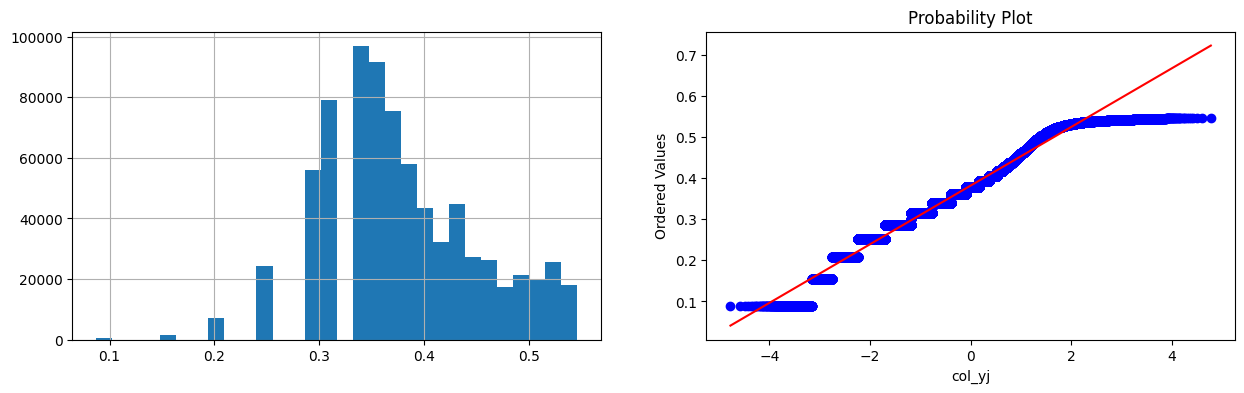

**1/1.5 plot


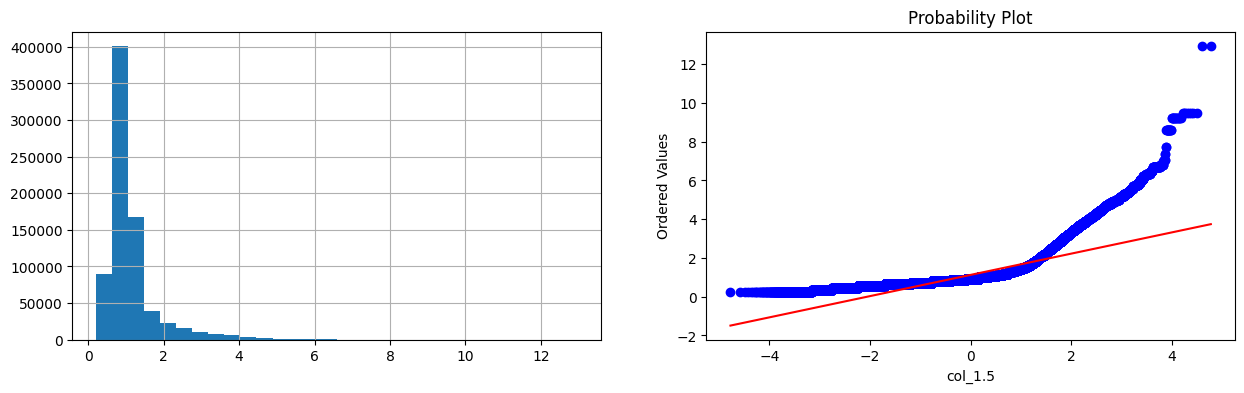

**.5 plot


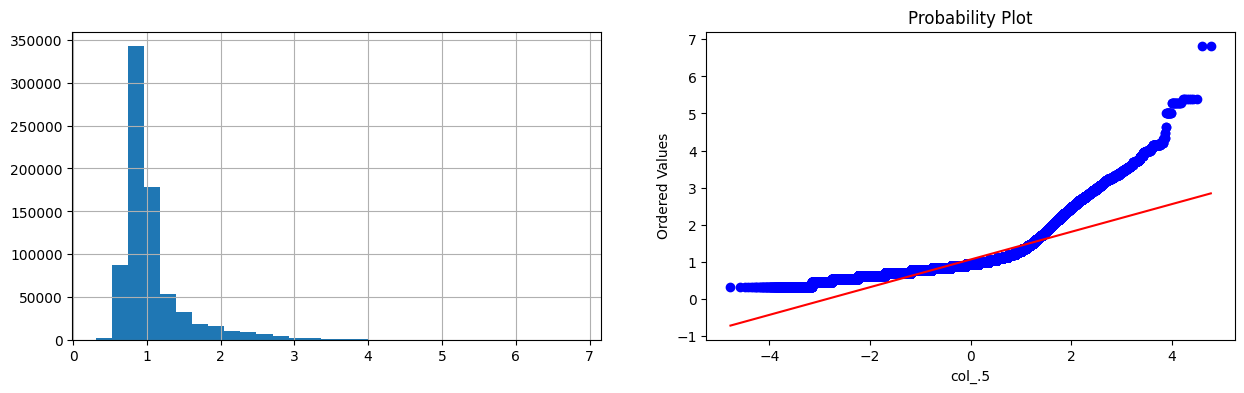

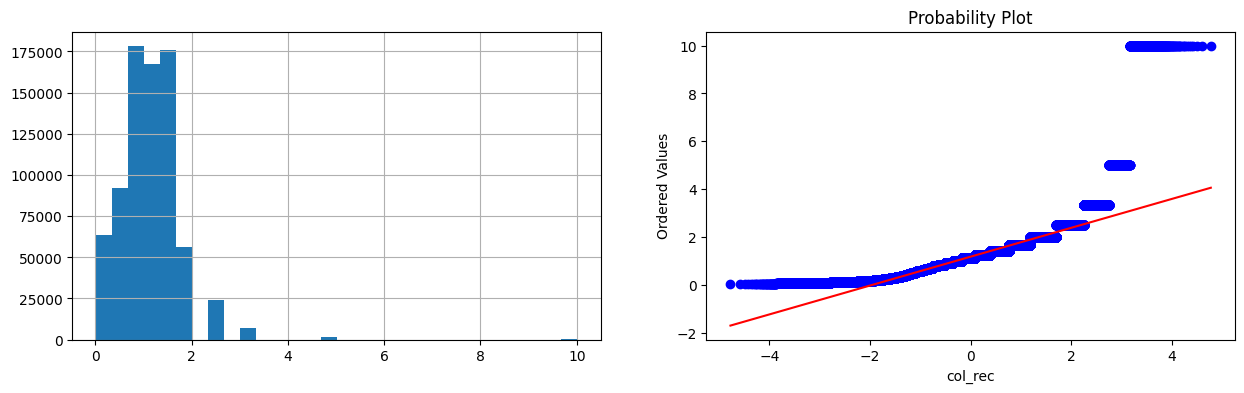

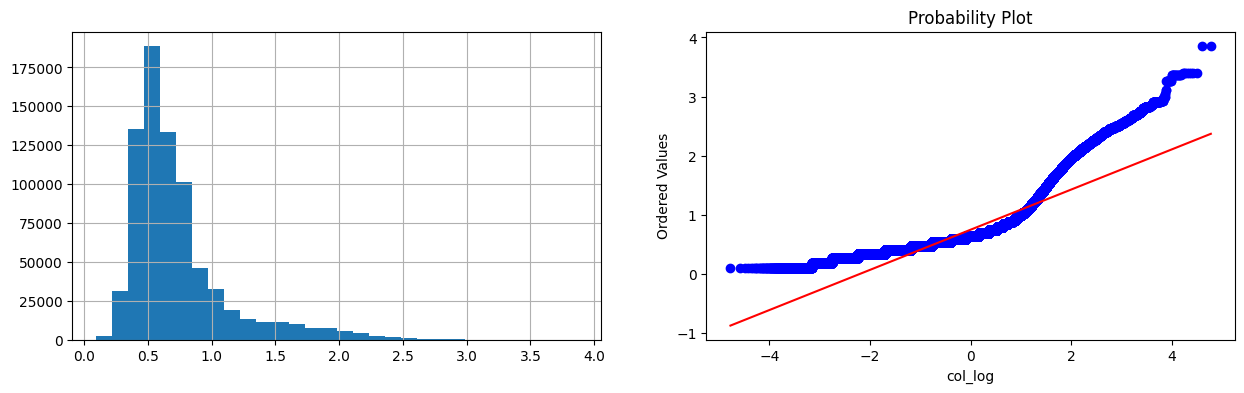

Glucose
actual plot


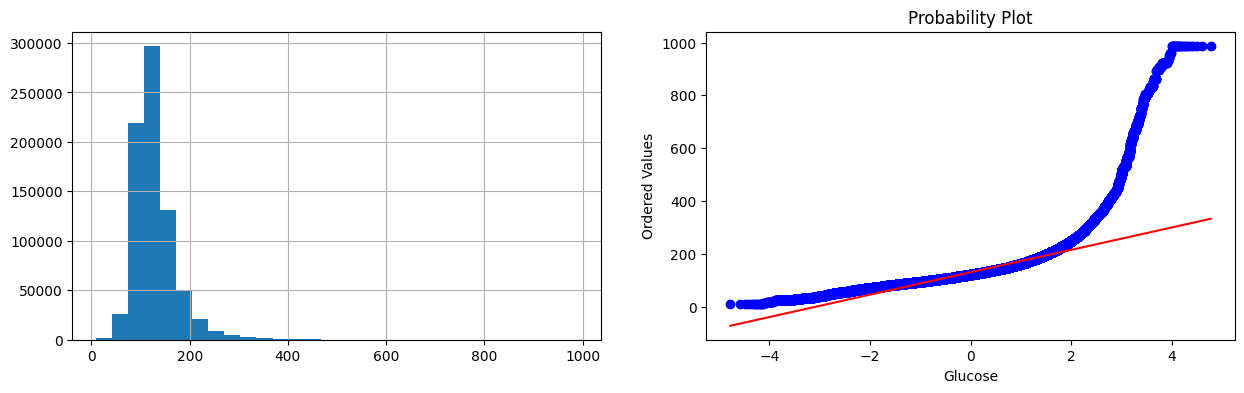

yeojohnson plot


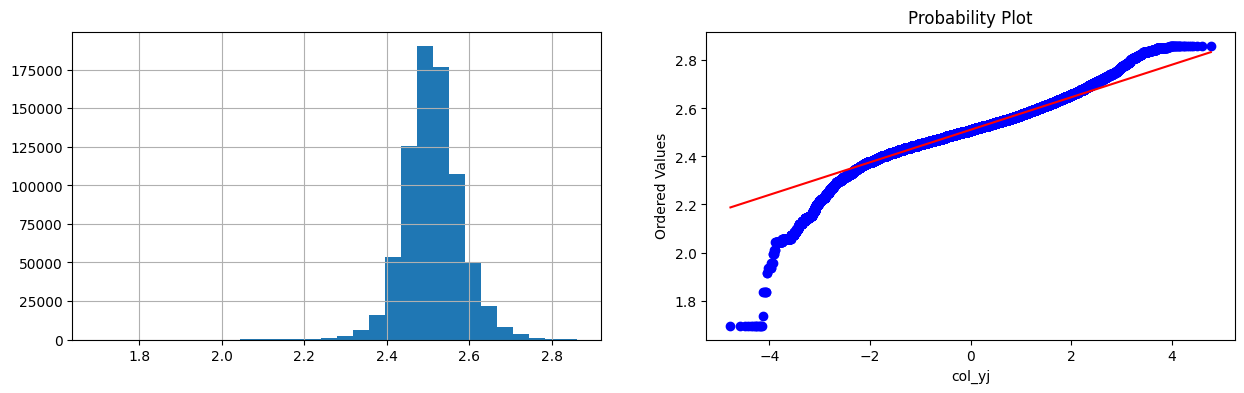

**1/1.5 plot


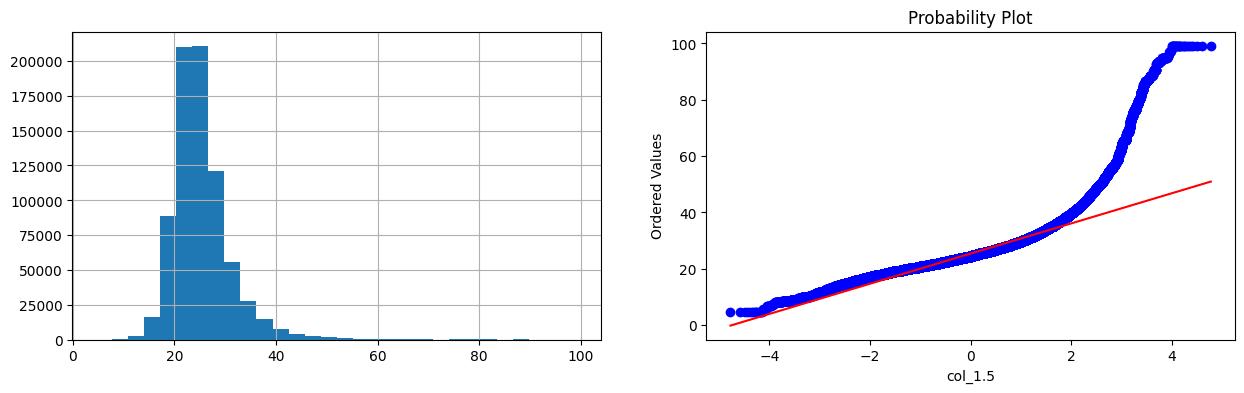

**.5 plot


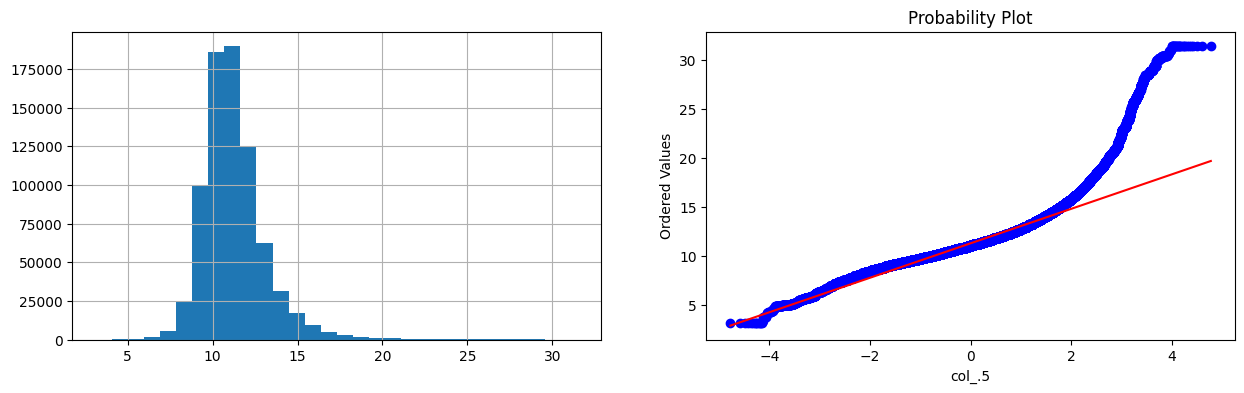

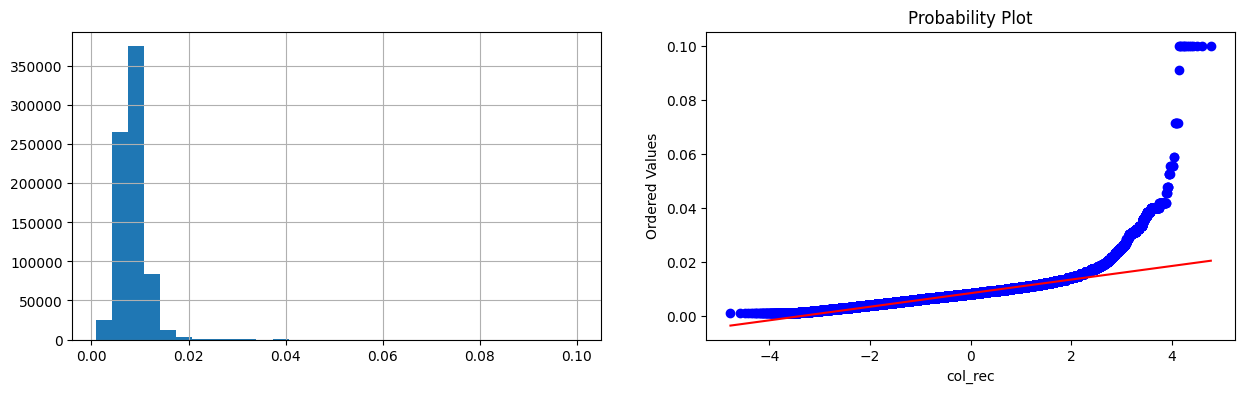

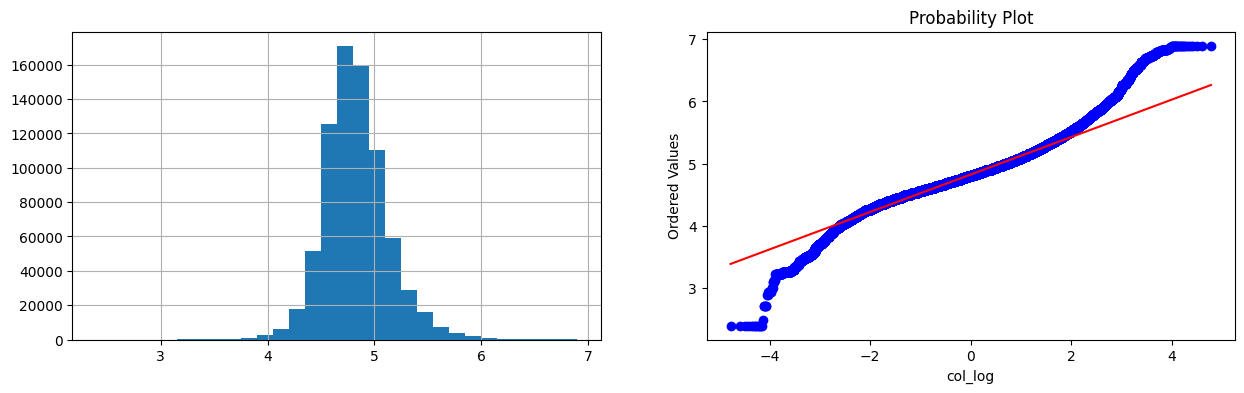

WBC
actual plot


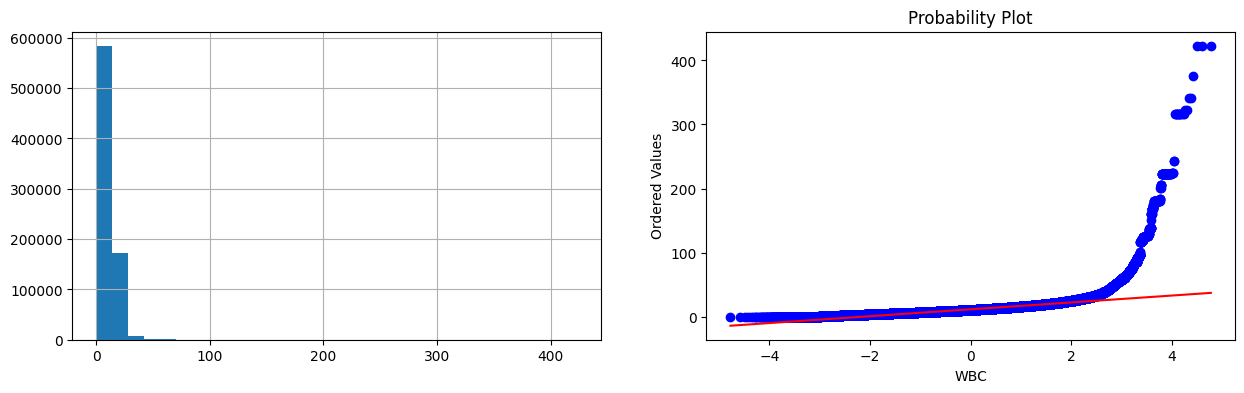

yeojohnson plot


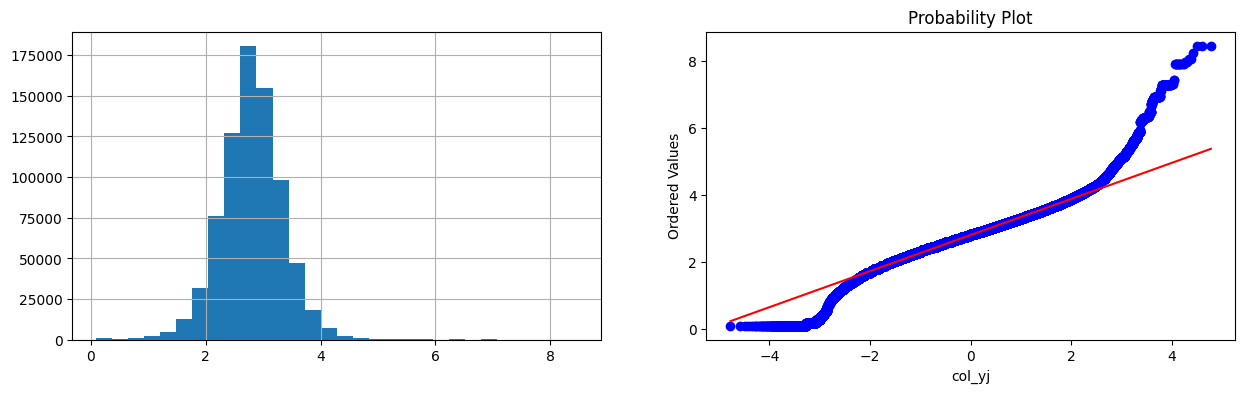

**1/1.5 plot


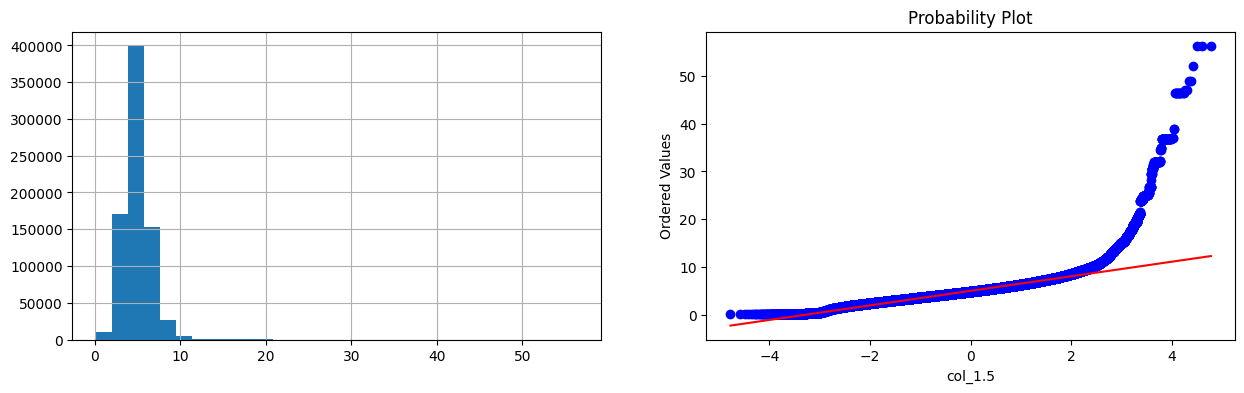

**.5 plot


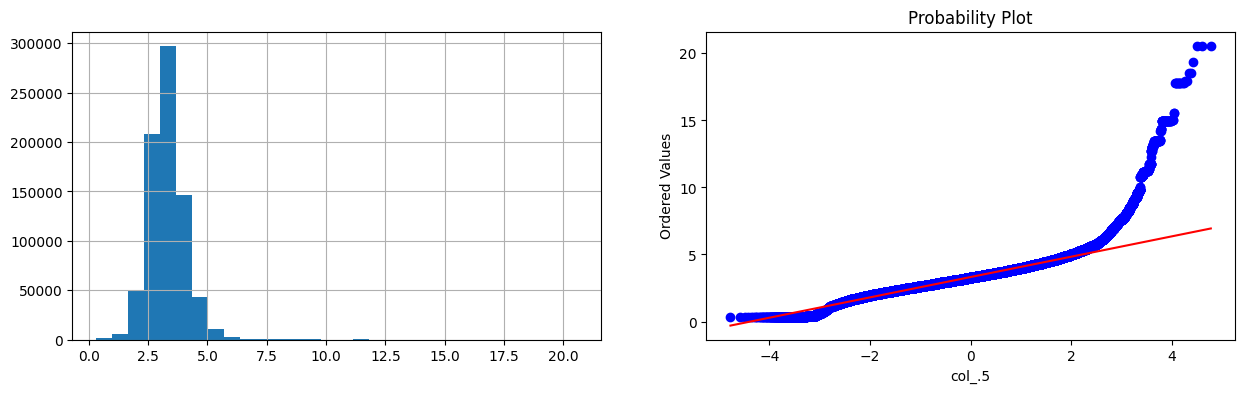

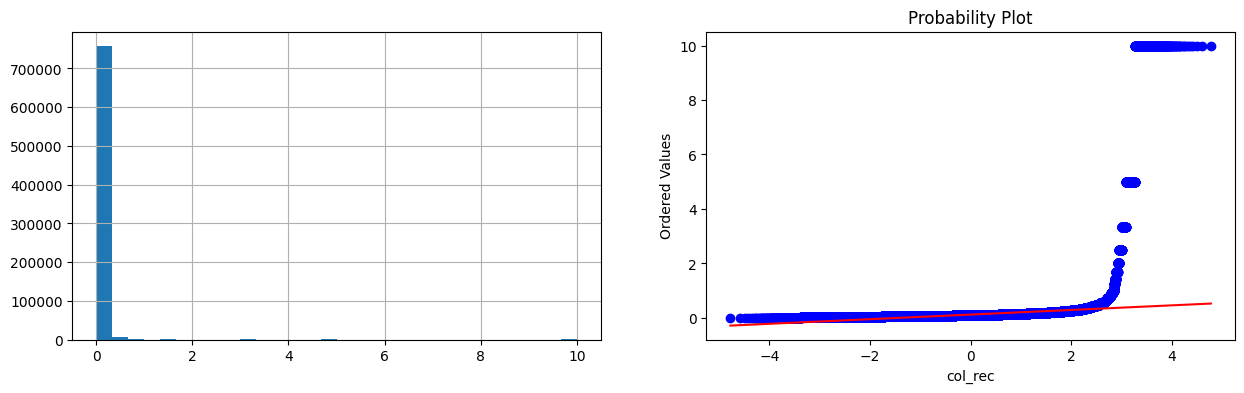

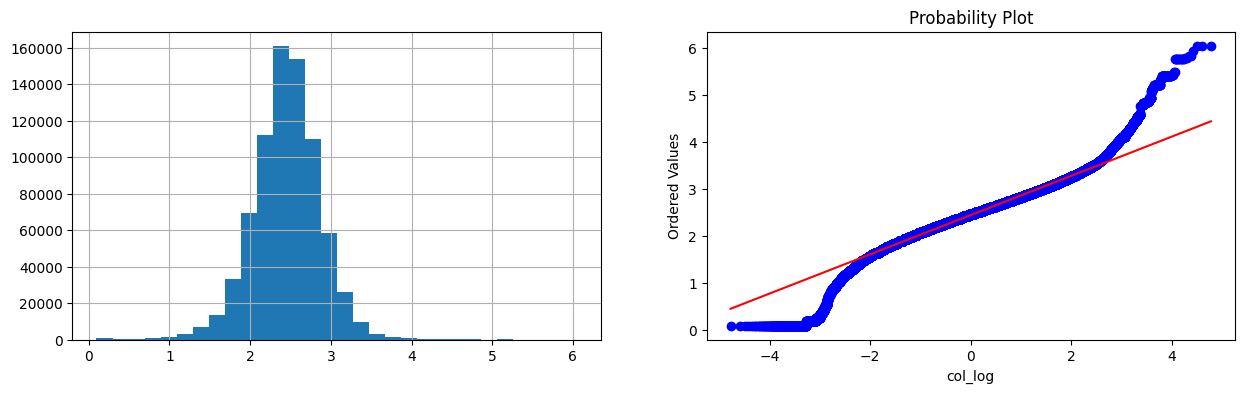

Platelets
actual plot


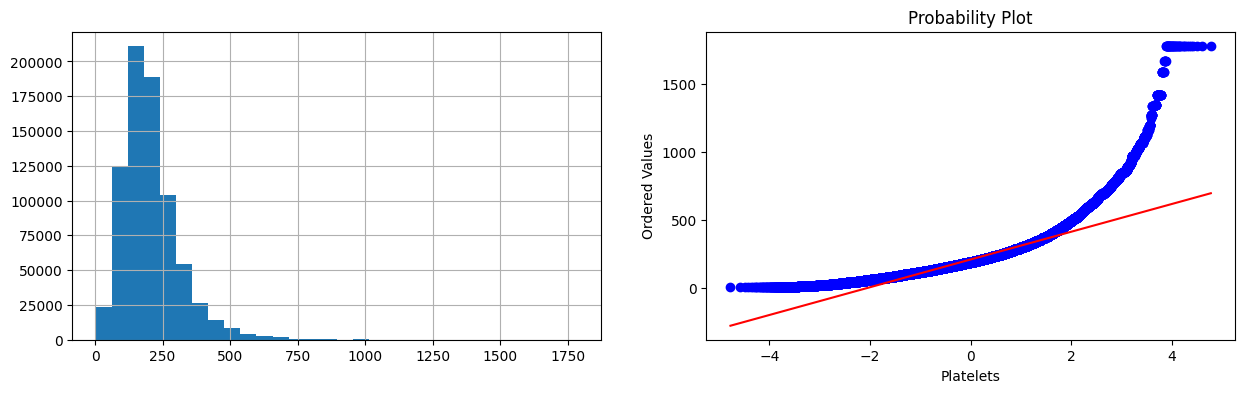

yeojohnson plot


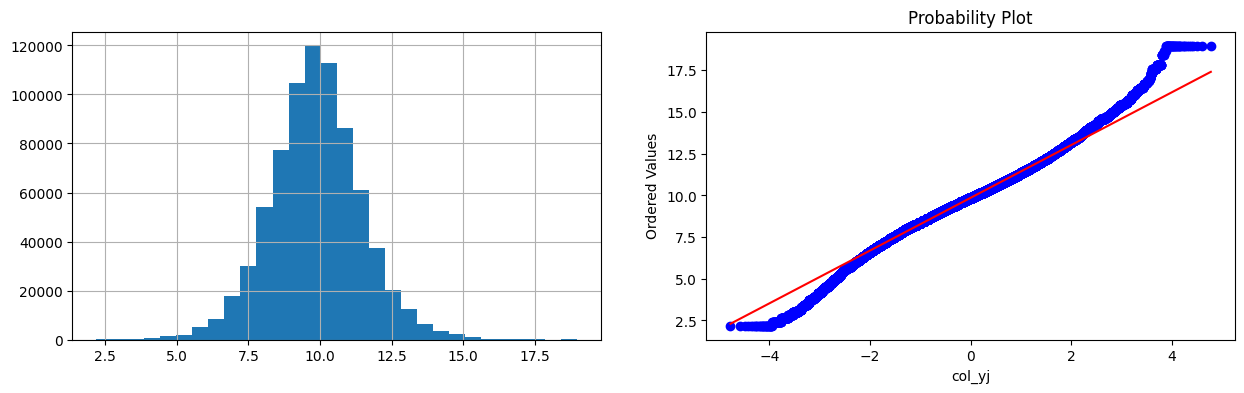

**1/1.5 plot


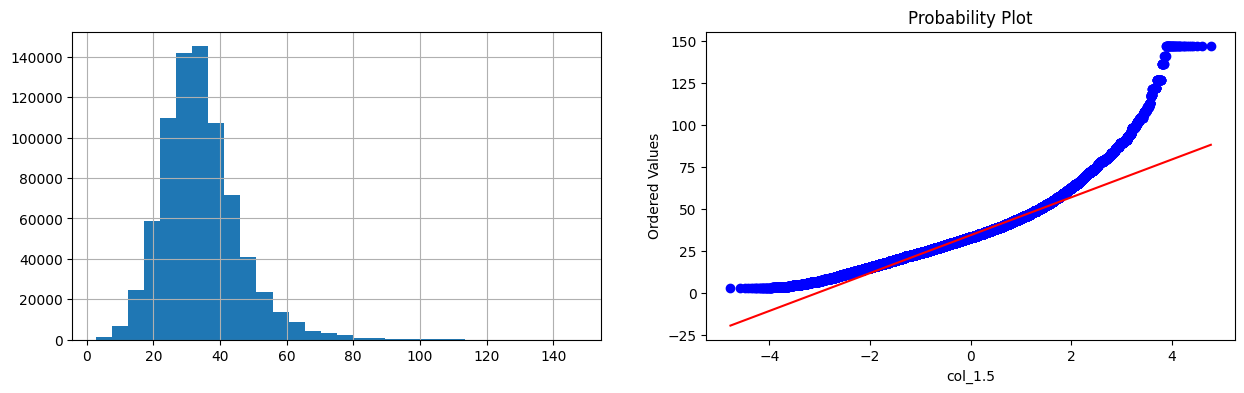

**.5 plot


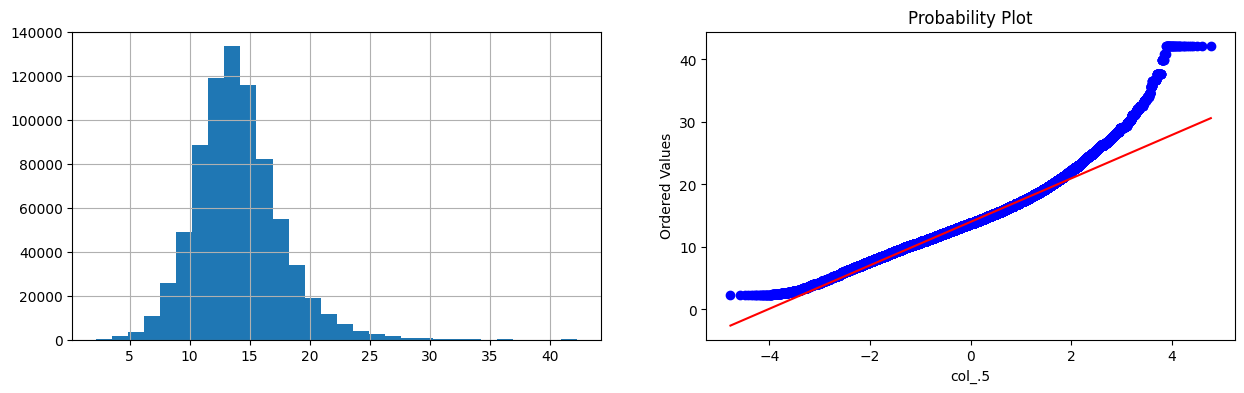

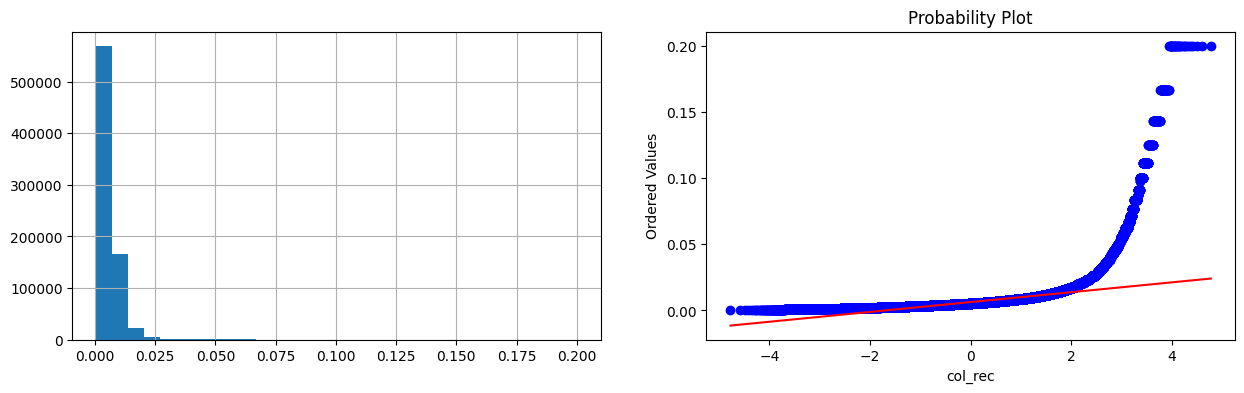

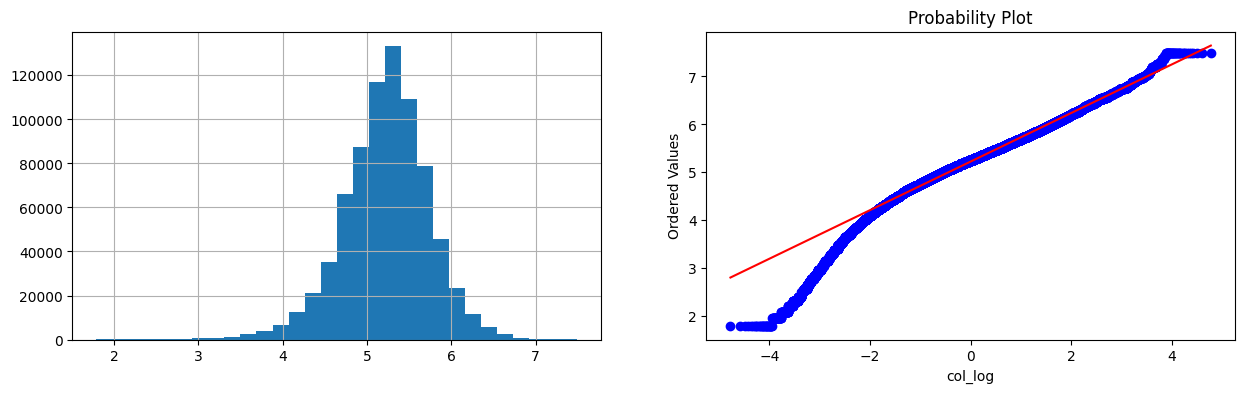

In [65]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
# Drop rows with missing values before applying transformations
df_train_impute_cleaned = df_train_impute.dropna()
for i in lst:
  print(i)
  try_gaussian(df_train_impute_cleaned, i)

In [66]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                  
1          132940     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                   Creatinine  Glucose   Hct   Hgb  WBC  Platelets    Age  \
Patient_ID                                                                  
1          132940         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132941         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132942         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132943         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132944         0.7    193.0  37.2  12.5  5.7      317.0  83.14   

                   HospAdmTime  ICULOS  SepsisLabel     0      1  
Patient_ID                                                        
1          132940        -0.03       1            0  True  False  
           132941        -0.03       2            0  True  False  
           132942        -0.03       3            0  True  False  
           132943        -0.03       4            0  True  False  
           132944        -0.03       5            0  True  False

In [67]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [68]:
df_train_impute.head()

Hour     HR  O2Sat   Temp       MAP  Resp      BUN  \
Patient_ID                                                              
1          132940     0   97.0   95.0  36.11  4.335066  19.0  2.70805   
           132941     1   97.0   95.0  36.11  4.335066  19.0  2.70805   
           132942     2   89.0   99.0  36.11  4.465908  22.0  2.70805   
           132943     3   90.0   95.0  36.11  4.525369  30.0  2.70805   
           132944     4  103.0   88.5  36.11  4.525369  24.5  2.70805   

                   Chloride  Creatinine   Glucose   Hct   Hgb       WBC  \
Patient_ID                                                                
1          132940      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           132941      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           132942      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           132943      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           132944      85.0    0.530628  5.267858  37.2  12.5  1.902108   

                   Platelets    Age  HospAdmTime  ICULOS  SepsisLabel     0  \
Patient_ID                                                                    
1          132940   5.762051  83.14        -0.03       1            0  True   
           132941   5.762051  83.14        -0.03       2            0  True   
           132942   5.762051  83.14        -0.03       3            0  True   
           132943   5.762051  83.14        -0.03       4            0  True   
           132944   5.762051  83.14        -0.03       5            0  True   

                       1  
Patient_ID                
1          132940  False  
           132941  False  
           132942  False  
           132943  False  
           132944  False

In [69]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685827 -1.105823 -0.157228  0.043895   
           132941     1  0.705950 -0.685827 -1.105823 -0.157228  0.043895   
           132942     2  0.236955  0.555029 -1.105823  0.547988  0.600192   
           132943     3  0.295579 -0.685827 -1.105823  0.868472  2.083649   
           132944     4  1.057696 -2.702217 -1.105823  0.868472  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132941 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132942 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132943 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132944 -0.413042 -3.697098   -0.560343  1.444179  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.288936   1.062522  83.14        -0.03       1   
           132941  1.114903 -1.288936   1.062522  83.14        -0.03       2   
           132942  1.114903 -1.288936   1.062522  83.14        -0.03       3   
           132943  1.114903 -1.288936   1.062522  83.14        -0.03       4   
           132944  1.114903 -1.288936   1.062522  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [70]:
df_train_impute = df_train_impute.dropna()

In [71]:
null_values = df_train_impute.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


# Model Building

In [72]:
# this function will transform the dataframe (for final testing) in the compatible
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  # Convert column names to strings
  df.columns = df.columns.astype(str)
  return df

In [73]:
# this fucntion calculates different evaluation parameters of a model

def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [74]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


So, this shows a clear imbalance between sepsis label 1 and label 0, to deal with this, we did undersampling.

In [75]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

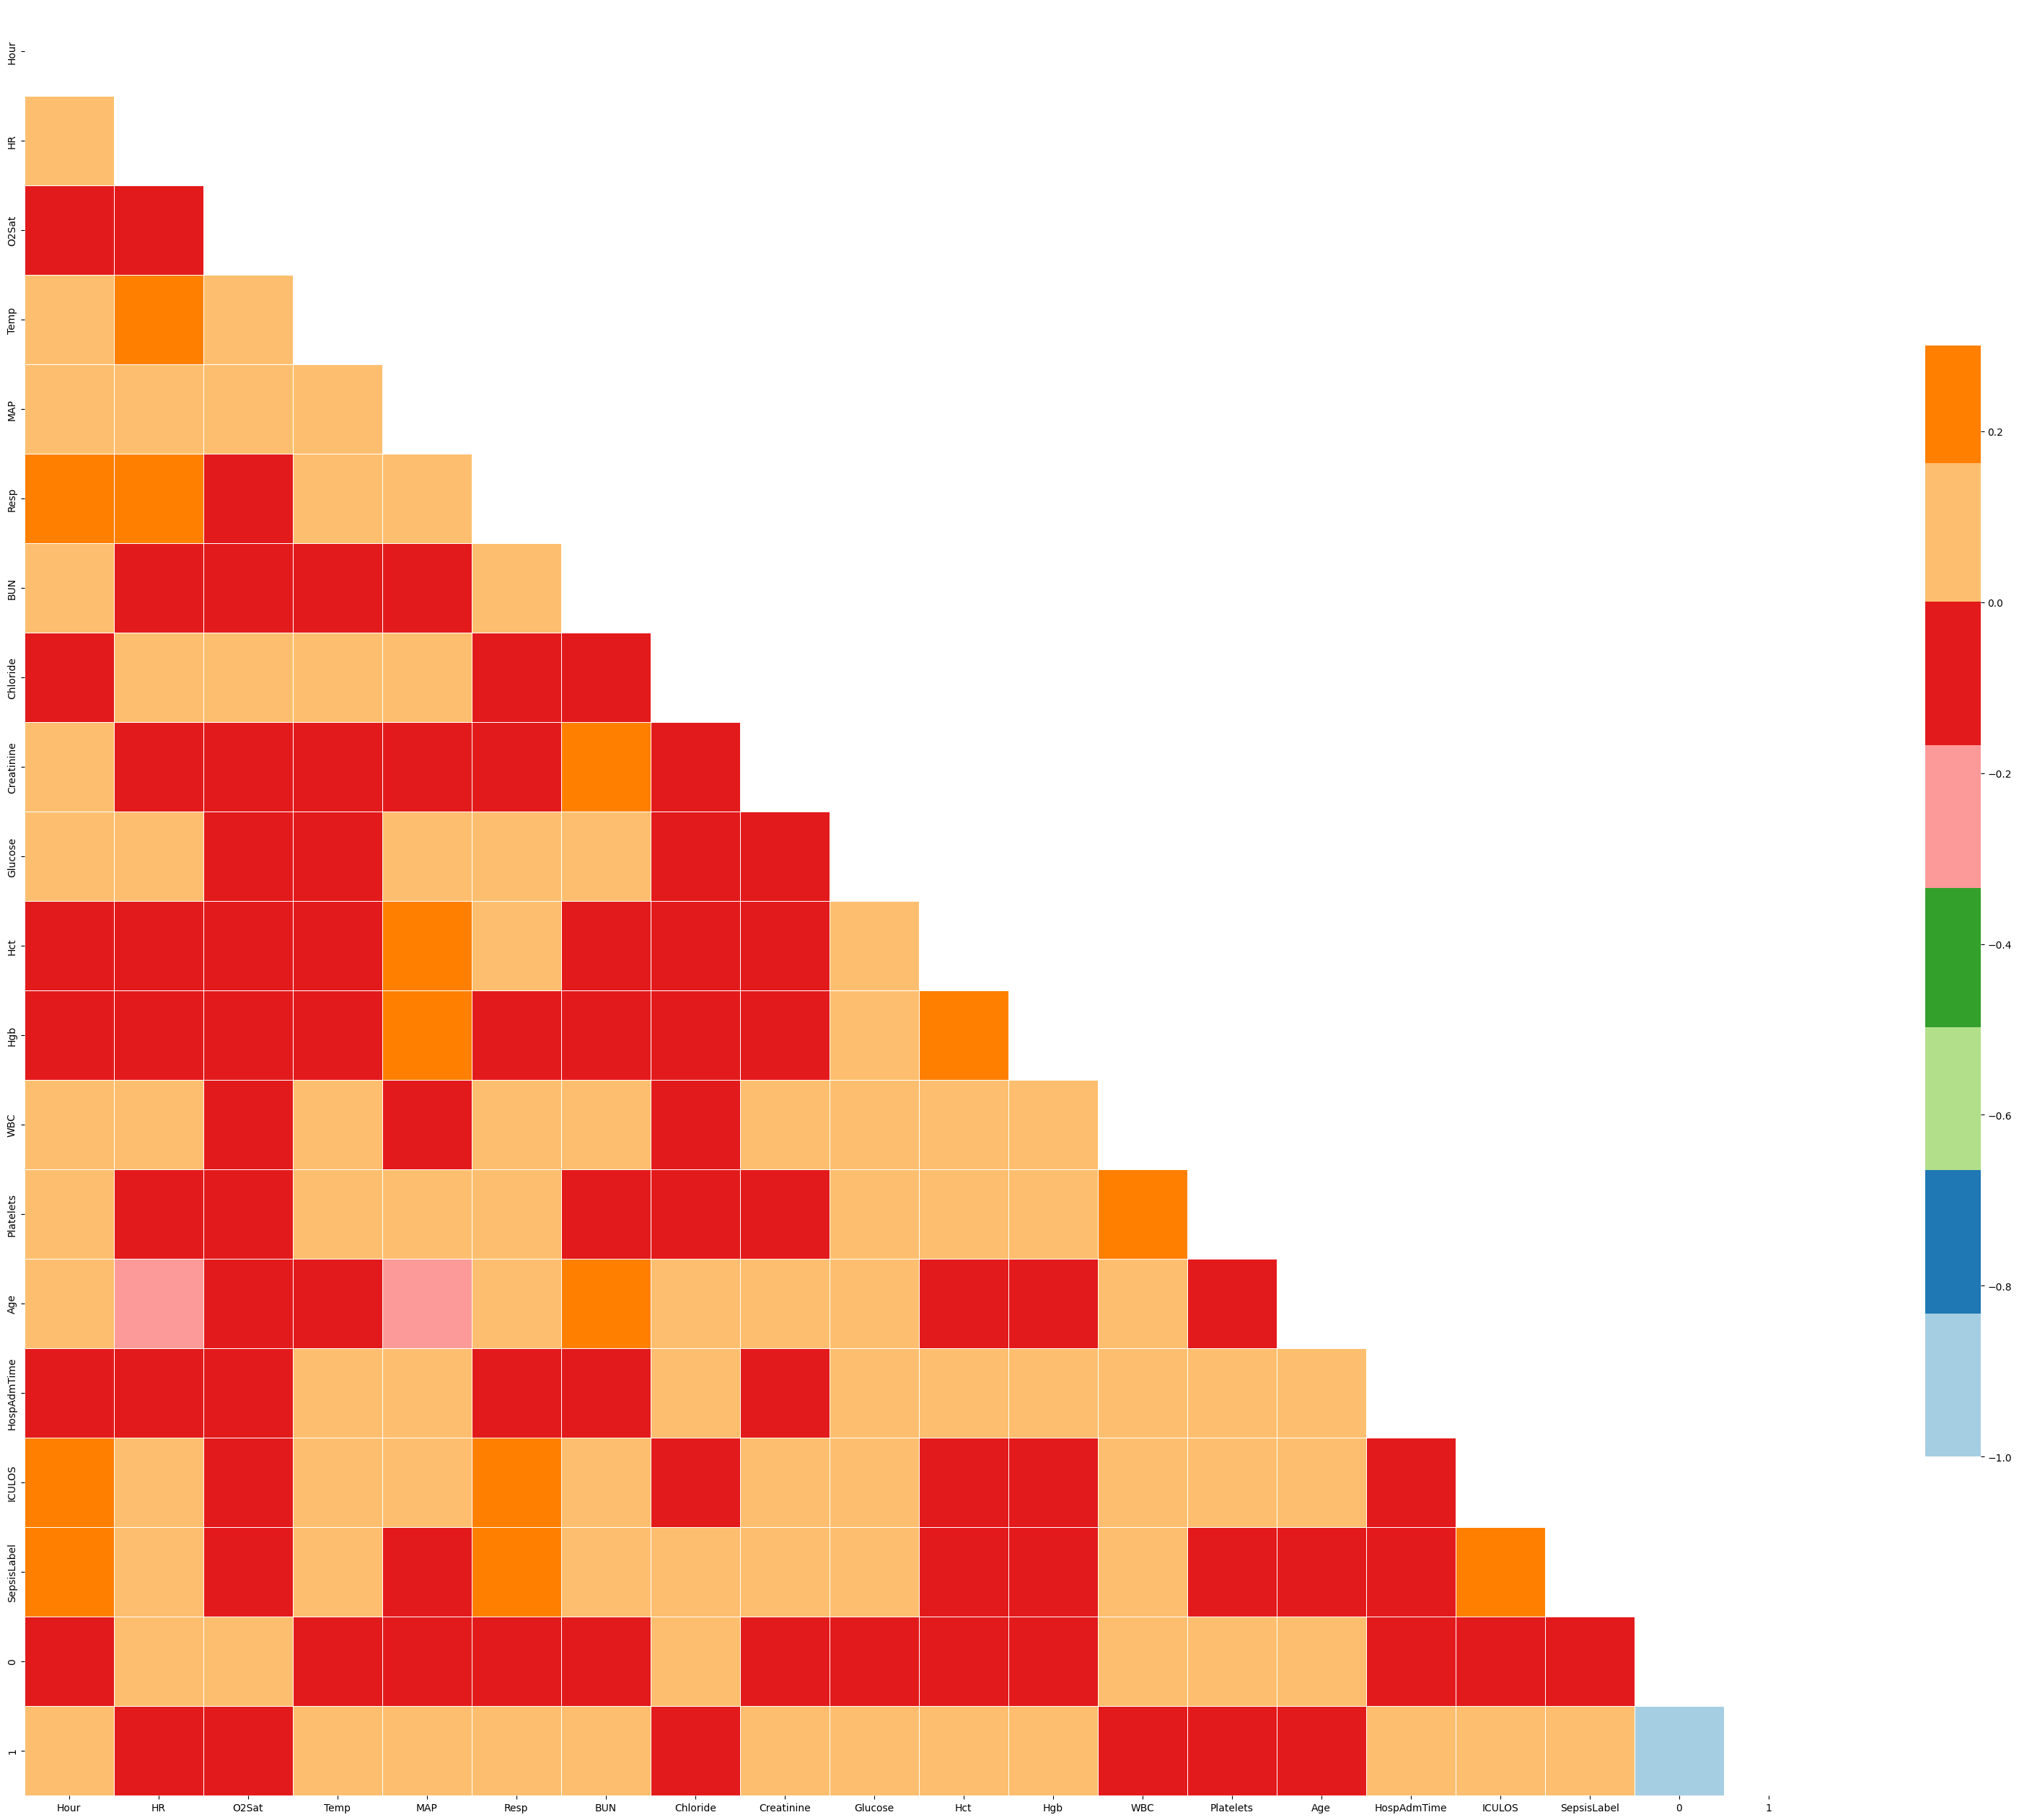

In [76]:
corr_matrix(df_train_impute)

# Testing on the data of the other hospital

/tmp/ipython-input-1592620272.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


Accuracy: 0.8390461194773036
Precision: 0.08304844492620696
Recall: 0.5084226646248086
F1 Score: 0.14277522935779816
AUC-ROC: 0.678210613564132
Mean Absolute Error: 0.16095388052269638
Root Mean Squared Error: 0.40119057880600384


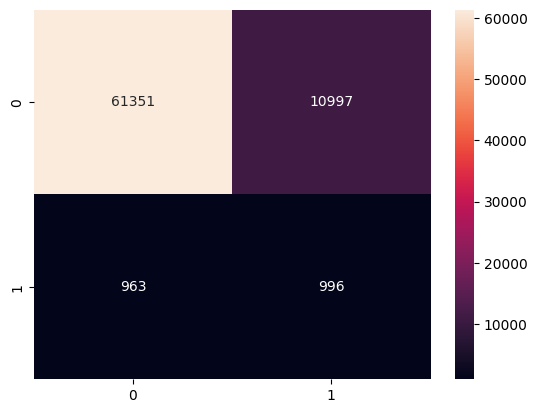

In [77]:
# testing on the other hospital data

df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

In this notebook several models were built to predict the onset of sepsis 6 hours before. After deep analysis several features were dropped and the remaining were imputed. Then the remaining features were applied with gaussian transformation and then normalized, so that a sngle feature won't start dominating the output. After all this exploration and feature engineering, several classifier models were run, in which Random Forest Classifier gave the best results.